In [1]:
!nvidia-smi

Fri Mar  1 15:59:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
| 54%   43C    P8    18W / 170W |    331MiB / 12288MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold3/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [9]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13mfcc_sm.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')

name: M13mfcc
description: FirConv with fftconv
mfcc:
  n_mfcc: 40
  n_fft: 512
  hop_length: 128
  n_mels: 64
  sample_rate: 16000
pooling: mean
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)
total parameters: 77394


In [10]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [11]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [12]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                       | 0.00411522633744856/10 [00:01<53:06, 318.79s/it]

Train Epoch: 1 [0/11751 (0%)]	Loss: 0.530230
Mem before-during-after: 389120 9054720 18361856


  1%|▌                                                                       | 0.08641975308641978/10 [00:08<14:48, 89.64s/it]

Train Epoch: 1 [1280/11751 (11%)]	Loss: 0.315364
Mem before-during-after: 18361856 18506752 18361856


  2%|█▏                                                                      | 0.16872427983539084/10 [00:16<14:43, 89.85s/it]

Train Epoch: 1 [2560/11751 (22%)]	Loss: 0.681726
Mem before-during-after: 18361856 18506752 18361856


  3%|█▊                                                                      | 0.25102880658436166/10 [00:23<15:06, 93.00s/it]

Train Epoch: 1 [3840/11751 (33%)]	Loss: 0.786461
Mem before-during-after: 18361856 18506752 18361856


  3%|██▍                                                                      | 0.3333333333333325/10 [00:31<14:25, 89.48s/it]

Train Epoch: 1 [5120/11751 (44%)]	Loss: 0.775346
Mem before-during-after: 18361856 18506752 18361856


  4%|███                                                                      | 0.4156378600823033/10 [00:38<14:12, 89.00s/it]

Train Epoch: 1 [6400/11751 (54%)]	Loss: 0.658684
Mem before-during-after: 18361856 18506752 18361856


  5%|███▋                                                                     | 0.4979423868312741/10 [00:46<14:22, 90.73s/it]

Train Epoch: 1 [7680/11751 (65%)]	Loss: 0.705629
Mem before-during-after: 18361856 18506752 18361856


  6%|████▎                                                                     | 0.580246913580247/10 [00:53<14:12, 90.54s/it]

Train Epoch: 1 [8960/11751 (76%)]	Loss: 0.562923
Mem before-during-after: 18361856 18506752 18361856


  7%|████▊                                                                    | 0.6625514403292201/10 [01:01<14:15, 91.62s/it]

Train Epoch: 1 [10240/11751 (87%)]	Loss: 0.196607
Mem before-during-after: 18361856 18506752 18361856


  7%|█████▍                                                                   | 0.7448559670781931/10 [01:08<13:57, 90.48s/it]

Train Epoch: 1 [11520/11751 (98%)]	Loss: 0.385889
Mem before-during-after: 18361856 18506752 18361856


 10%|███████▎                                                                 | 1.0020576131687338/10 [01:31<13:21, 89.07s/it]


Test Epoch: 1	Accuracy: 2910/3808 (76%)

Train Epoch: 2 [0/11751 (0%)]	Loss: 0.013960
Mem before-during-after: 18360832 18506752 18361856


 11%|███████▉                                                                 | 1.0864197530864266/10 [01:39<13:32, 91.17s/it]

Train Epoch: 2 [1280/11751 (11%)]	Loss: 0.049050
Mem before-during-after: 18361856 18506752 18361856


 12%|████████▌                                                                | 1.1687242798353952/10 [01:46<13:12, 89.74s/it]

Train Epoch: 2 [2560/11751 (22%)]	Loss: 0.633402
Mem before-during-after: 18361856 18506752 18361856


 13%|█████████▏                                                               | 1.2510288065843638/10 [01:53<13:06, 89.92s/it]

Train Epoch: 2 [3840/11751 (33%)]	Loss: 0.263163
Mem before-during-after: 18361856 18506752 18361856


 13%|█████████▋                                                               | 1.3333333333333324/10 [02:01<12:44, 88.18s/it]

Train Epoch: 2 [5120/11751 (44%)]	Loss: 0.779968
Mem before-during-after: 18361856 18506752 18361856


 14%|██████████▍                                                               | 1.415637860082301/10 [02:08<12:45, 89.21s/it]

Train Epoch: 2 [6400/11751 (54%)]	Loss: 0.638202
Mem before-during-after: 18361856 18506752 18361856


 15%|██████████▉                                                              | 1.4979423868312696/10 [02:16<12:50, 90.63s/it]

Train Epoch: 2 [7680/11751 (65%)]	Loss: 0.266706
Mem before-during-after: 18361856 18506752 18361856


 16%|███████████▌                                                             | 1.5802469135802382/10 [02:23<12:27, 88.80s/it]

Train Epoch: 2 [8960/11751 (76%)]	Loss: 1.236574
Mem before-during-after: 18361856 18506752 18361856


 17%|████████████▏                                                            | 1.6625514403292068/10 [02:30<12:42, 91.50s/it]

Train Epoch: 2 [10240/11751 (87%)]	Loss: 0.272613
Mem before-during-after: 18361856 18506752 18361856


 17%|████████████▋                                                            | 1.7448559670781754/10 [02:38<12:57, 94.21s/it]

Train Epoch: 2 [11520/11751 (98%)]	Loss: 0.148461
Mem before-during-after: 18361856 18506752 18361856


 20%|██████████████▌                                                          | 2.0020576131687022/10 [03:00<11:34, 86.79s/it]


Test Epoch: 2	Accuracy: 3263/3808 (85%)

Train Epoch: 3 [0/11751 (0%)]	Loss: 0.003215
Mem before-during-after: 18360832 18506752 18361856


 21%|███████████████▍                                                          | 2.086419753086404/10 [03:08<11:36, 87.97s/it]

Train Epoch: 3 [1280/11751 (11%)]	Loss: 0.011015
Mem before-during-after: 18361856 18506752 18361856


 22%|███████████████▊                                                         | 2.1687242798353816/10 [03:15<11:47, 90.37s/it]

Train Epoch: 3 [2560/11751 (22%)]	Loss: 0.226237
Mem before-during-after: 18361856 18506752 18361856


 23%|████████████████▋                                                         | 2.251028806584359/10 [03:22<11:29, 89.03s/it]

Train Epoch: 3 [3840/11751 (33%)]	Loss: 0.174043
Mem before-during-after: 18361856 18506752 18361856


 23%|█████████████████                                                        | 2.3333333333333366/10 [03:30<11:12, 87.71s/it]

Train Epoch: 3 [5120/11751 (44%)]	Loss: 0.554884
Mem before-during-after: 18361856 18506752 18361856


 24%|█████████████████▉                                                        | 2.415637860082314/10 [03:37<11:02, 87.31s/it]

Train Epoch: 3 [6400/11751 (54%)]	Loss: 0.400773
Mem before-during-after: 18361856 18506752 18361856


 25%|██████████████████▏                                                      | 2.4979423868312916/10 [03:44<10:53, 87.07s/it]

Train Epoch: 3 [7680/11751 (65%)]	Loss: 0.242309
Mem before-during-after: 18361856 18506752 18361856


 26%|███████████████████                                                       | 2.580246913580269/10 [03:51<10:55, 88.39s/it]

Train Epoch: 3 [8960/11751 (76%)]	Loss: 0.865334
Mem before-during-after: 18361856 18506752 18361856


 27%|███████████████████▍                                                     | 2.6625514403292465/10 [03:59<10:48, 88.33s/it]

Train Epoch: 3 [10240/11751 (87%)]	Loss: 0.182105
Mem before-during-after: 18361856 18506752 18361856


 27%|████████████████████▎                                                     | 2.744855967078224/10 [04:06<10:36, 87.75s/it]

Train Epoch: 3 [11520/11751 (98%)]	Loss: 0.148383
Mem before-during-after: 18361856 18506752 18361856


 30%|█████████████████████▉                                                   | 3.0020576131687786/10 [04:28<10:10, 87.19s/it]


Test Epoch: 3	Accuracy: 3270/3808 (86%)

Train Epoch: 4 [0/11751 (0%)]	Loss: 0.003846
Mem before-during-after: 18360832 18506752 18361856


 31%|██████████████████████▌                                                  | 3.0864197530864805/10 [04:36<10:03, 87.36s/it]

Train Epoch: 4 [1280/11751 (11%)]	Loss: 0.012753
Mem before-during-after: 18361856 18506752 18361856


 32%|███████████████████████▍                                                  | 3.168724279835458/10 [04:43<09:58, 87.63s/it]

Train Epoch: 4 [2560/11751 (22%)]	Loss: 0.154655
Mem before-during-after: 18361856 18506752 18361856


 33%|███████████████████████▋                                                 | 3.2510288065844355/10 [04:50<10:33, 93.81s/it]

Train Epoch: 4 [3840/11751 (33%)]	Loss: 0.102593
Mem before-during-after: 18361856 18506752 18361856


 33%|████████████████████████▋                                                 | 3.333333333333413/10 [04:57<09:49, 88.45s/it]

Train Epoch: 4 [5120/11751 (44%)]	Loss: 0.532804
Mem before-during-after: 18361856 18506752 18361856


 34%|████████████████████████▉                                                | 3.4156378600823905/10 [05:05<09:37, 87.74s/it]

Train Epoch: 4 [6400/11751 (54%)]	Loss: 0.434852
Mem before-during-after: 18361856 18506752 18361856


 35%|█████████████████████████▉                                                | 3.497942386831368/10 [05:12<09:35, 88.51s/it]

Train Epoch: 4 [7680/11751 (65%)]	Loss: 0.260071
Mem before-during-after: 18361856 18506752 18361856


 36%|██████████████████████████▏                                              | 3.5802469135803454/10 [05:19<09:23, 87.73s/it]

Train Epoch: 4 [8960/11751 (76%)]	Loss: 0.901589
Mem before-during-after: 18361856 18506752 18361856


 37%|███████████████████████████                                               | 3.662551440329323/10 [05:26<09:16, 87.86s/it]

Train Epoch: 4 [10240/11751 (87%)]	Loss: 0.247036
Mem before-during-after: 18361856 18506752 18361856


 37%|███████████████████████████▎                                             | 3.7448559670783004/10 [05:34<09:08, 87.69s/it]

Train Epoch: 4 [11520/11751 (98%)]	Loss: 0.167273
Mem before-during-after: 18361856 18506752 18361856


 40%|█████████████████████████████▌                                            | 4.002057613168855/10 [05:56<08:41, 86.96s/it]


Test Epoch: 4	Accuracy: 3236/3808 (85%)

Train Epoch: 5 [0/11751 (0%)]	Loss: 0.001144
Mem before-during-after: 18360832 18506752 18361856


 41%|██████████████████████████████▏                                           | 4.086419753086557/10 [06:03<08:42, 88.29s/it]

Train Epoch: 5 [1280/11751 (11%)]	Loss: 0.004849
Mem before-during-after: 18361856 18506752 18361856


 42%|██████████████████████████████▊                                           | 4.168724279835534/10 [06:11<08:35, 88.34s/it]

Train Epoch: 5 [2560/11751 (22%)]	Loss: 0.116139
Mem before-during-after: 18361856 18506752 18361856


 43%|███████████████████████████████▍                                          | 4.251028806584512/10 [06:18<08:29, 88.62s/it]

Train Epoch: 5 [3840/11751 (33%)]	Loss: 0.181914
Mem before-during-after: 18361856 18506752 18361856


 43%|████████████████████████████████                                          | 4.333333333333489/10 [06:25<08:48, 93.29s/it]

Train Epoch: 5 [5120/11751 (44%)]	Loss: 0.791300
Mem before-during-after: 18361856 18506752 18361856


 44%|████████████████████████████████▋                                         | 4.415637860082467/10 [06:33<08:19, 89.39s/it]

Train Epoch: 5 [6400/11751 (54%)]	Loss: 0.443128
Mem before-during-after: 18361856 18506752 18361856


 45%|█████████████████████████████████▎                                        | 4.497942386831444/10 [06:40<08:12, 89.44s/it]

Train Epoch: 5 [7680/11751 (65%)]	Loss: 0.277917
Mem before-during-after: 18361856 18506752 18361856


 46%|█████████████████████████████████▉                                        | 4.580246913580422/10 [06:47<08:03, 89.27s/it]

Train Epoch: 5 [8960/11751 (76%)]	Loss: 1.049253
Mem before-during-after: 18361856 18506752 18361856


 47%|██████████████████████████████████▌                                       | 4.662551440329399/10 [06:54<07:49, 88.05s/it]

Train Epoch: 5 [10240/11751 (87%)]	Loss: 0.193879
Mem before-during-after: 18361856 18506752 18361856


 47%|███████████████████████████████████                                       | 4.744855967078377/10 [07:02<07:41, 87.86s/it]

Train Epoch: 5 [11520/11751 (98%)]	Loss: 0.130629
Mem before-during-after: 18361856 18506752 18361856


 50%|█████████████████████████████████████                                     | 5.002057613168931/10 [07:24<07:13, 86.82s/it]


Test Epoch: 5	Accuracy: 3248/3808 (85%)

Train Epoch: 6 [0/11751 (0%)]	Loss: 0.005294
Mem before-during-after: 18360832 18506752 18361856


 51%|█████████████████████████████████████▋                                    | 5.086419753086633/10 [07:32<07:16, 88.76s/it]

Train Epoch: 6 [1280/11751 (11%)]	Loss: 0.003817
Mem before-during-after: 18361856 18506752 18361856


 52%|██████████████████████████████████████▏                                   | 5.168724279835611/10 [07:39<07:07, 88.50s/it]

Train Epoch: 6 [2560/11751 (22%)]	Loss: 0.175835
Mem before-during-after: 18361856 18506752 18361856


 53%|██████████████████████████████████████▊                                   | 5.251028806584588/10 [07:46<07:00, 88.56s/it]

Train Epoch: 6 [3840/11751 (33%)]	Loss: 0.076408
Mem before-during-after: 18361856 18506752 18361856


 53%|███████████████████████████████████████▍                                  | 5.333333333333566/10 [07:53<06:48, 87.60s/it]

Train Epoch: 6 [5120/11751 (44%)]	Loss: 1.041988
Mem before-during-after: 18361856 18506752 18361856


 54%|████████████████████████████████████████                                  | 5.415637860082543/10 [08:01<06:45, 88.43s/it]

Train Epoch: 6 [6400/11751 (54%)]	Loss: 0.265757
Mem before-during-after: 18361856 18506752 18361856


 55%|████████████████████████████████████████▋                                 | 5.497942386831521/10 [08:08<06:38, 88.43s/it]

Train Epoch: 6 [7680/11751 (65%)]	Loss: 0.308167
Mem before-during-after: 18361856 18506752 18361856


 56%|█████████████████████████████████████████▎                                | 5.580246913580498/10 [08:15<06:29, 88.13s/it]

Train Epoch: 6 [8960/11751 (76%)]	Loss: 1.122810
Mem before-during-after: 18361856 18506752 18361856


 57%|█████████████████████████████████████████▉                                | 5.662551440329476/10 [08:22<06:20, 87.76s/it]

Train Epoch: 6 [10240/11751 (87%)]	Loss: 0.224766
Mem before-during-after: 18361856 18506752 18361856


 57%|██████████████████████████████████████████▌                               | 5.744855967078453/10 [08:30<06:15, 88.13s/it]

Train Epoch: 6 [11520/11751 (98%)]	Loss: 0.111357
Mem before-during-after: 18361856 18506752 18361856


 60%|████████████████████████████████████████████▍                             | 6.002057613169008/10 [08:52<05:55, 88.80s/it]


Test Epoch: 6	Accuracy: 3260/3808 (85%)

Train Epoch: 7 [0/11751 (0%)]	Loss: 0.004105
Mem before-during-after: 18360832 18506752 18361856


 61%|█████████████████████████████████████████████▋                             | 6.08641975308671/10 [09:00<05:45, 88.30s/it]

Train Epoch: 7 [1280/11751 (11%)]	Loss: 0.000493
Mem before-during-after: 18361856 18506752 18361856


 62%|█████████████████████████████████████████████▋                            | 6.168724279835687/10 [09:07<05:36, 87.80s/it]

Train Epoch: 7 [2560/11751 (22%)]	Loss: 0.270068
Mem before-during-after: 18361856 18506752 18361856


 63%|██████████████████████████████████████████████▎                           | 6.251028806584665/10 [09:14<05:30, 88.23s/it]

Train Epoch: 7 [3840/11751 (33%)]	Loss: 0.007046
Mem before-during-after: 18361856 18506752 18361856


 63%|██████████████████████████████████████████████▊                           | 6.333333333333642/10 [09:21<05:22, 87.95s/it]

Train Epoch: 7 [5120/11751 (44%)]	Loss: 0.621255
Mem before-during-after: 18361856 18506752 18361856


 64%|████████████████████████████████████████████████                           | 6.41563786008262/10 [09:29<05:16, 88.25s/it]

Train Epoch: 7 [6400/11751 (54%)]	Loss: 0.267589
Mem before-during-after: 18361856 18506752 18361856


 65%|████████████████████████████████████████████████                          | 6.497942386831597/10 [09:36<05:09, 88.40s/it]

Train Epoch: 7 [7680/11751 (65%)]	Loss: 0.242771
Mem before-during-after: 18361856 18506752 18361856


 66%|████████████████████████████████████████████████▋                         | 6.580246913580575/10 [09:43<05:00, 87.95s/it]

Train Epoch: 7 [8960/11751 (76%)]	Loss: 1.168790
Mem before-during-after: 18361856 18506752 18361856


 67%|█████████████████████████████████████████████████▎                        | 6.662551440329552/10 [09:50<04:54, 88.29s/it]

Train Epoch: 7 [10240/11751 (87%)]	Loss: 0.176214
Mem before-during-after: 18361856 18506752 18361856


 67%|█████████████████████████████████████████████████▏                       | 6.7448559670785295/10 [09:58<04:45, 87.77s/it]

Train Epoch: 7 [11520/11751 (98%)]	Loss: 0.133114
Mem before-during-after: 18361856 18506752 18361856


 70%|███████████████████████████████████████████████████▊                      | 7.002057613169084/10 [10:20<04:22, 87.64s/it]


Test Epoch: 7	Accuracy: 3258/3808 (85%)

Train Epoch: 8 [0/11751 (0%)]	Loss: 0.005628
Mem before-during-after: 18360832 18506752 18361856


 71%|████████████████████████████████████████████████████▍                     | 7.086419753086786/10 [10:28<04:19, 89.13s/it]

Train Epoch: 8 [1280/11751 (11%)]	Loss: 0.000832
Mem before-during-after: 18361856 18506752 18361856


 72%|████████████████████████████████████████████████████▎                    | 7.1687242798357635/10 [10:35<04:09, 88.10s/it]

Train Epoch: 8 [2560/11751 (22%)]	Loss: 0.146990
Mem before-during-after: 18361856 18506752 18361856


 73%|█████████████████████████████████████████████████████▋                    | 7.251028806584741/10 [10:42<04:03, 88.69s/it]

Train Epoch: 8 [3840/11751 (33%)]	Loss: 0.160047
Mem before-during-after: 18361856 18506752 18361856


 73%|█████████████████████████████████████████████████████▌                   | 7.3333333333337185/10 [10:49<03:56, 88.63s/it]

Train Epoch: 8 [5120/11751 (44%)]	Loss: 0.256154
Mem before-during-after: 18361856 18506752 18361856


 74%|██████████████████████████████████████████████████████▉                   | 7.415637860082696/10 [10:57<03:48, 88.34s/it]

Train Epoch: 8 [6400/11751 (54%)]	Loss: 0.194727
Mem before-during-after: 18361856 18506752 18361856


 75%|██████████████████████████████████████████████████████▋                  | 7.4979423868316735/10 [11:04<03:39, 87.91s/it]

Train Epoch: 8 [7680/11751 (65%)]	Loss: 0.304938
Mem before-during-after: 18361856 18506752 18361856


 76%|████████████████████████████████████████████████████████                  | 7.580246913580651/10 [11:11<03:32, 87.77s/it]

Train Epoch: 8 [8960/11751 (76%)]	Loss: 1.151713
Mem before-during-after: 18361856 18506752 18361856


 77%|████████████████████████████████████████████████████████▋                 | 7.662551440329628/10 [11:19<03:26, 88.18s/it]

Train Epoch: 8 [10240/11751 (87%)]	Loss: 0.154348
Mem before-during-after: 18361856 18506752 18361856


 77%|█████████████████████████████████████████████████████████▎                | 7.744855967078606/10 [11:26<03:19, 88.61s/it]

Train Epoch: 8 [11520/11751 (98%)]	Loss: 0.199638
Mem before-during-after: 18361856 18506752 18361856


 80%|███████████████████████████████████████████████████████████▏              | 8.002057613169159/10 [11:48<03:07, 93.63s/it]


Test Epoch: 8	Accuracy: 3249/3808 (85%)

Train Epoch: 9 [0/11751 (0%)]	Loss: 0.006756
Mem before-during-after: 18360832 18506752 18361856


 81%|███████████████████████████████████████████████████████████▊              | 8.086419753086824/10 [11:56<02:49, 88.47s/it]

Train Epoch: 9 [1280/11751 (11%)]	Loss: 0.006828
Mem before-during-after: 18361856 18506752 18361856


 82%|████████████████████████████████████████████████████████████▍             | 8.168724279835766/10 [12:03<02:40, 87.80s/it]

Train Epoch: 9 [2560/11751 (22%)]	Loss: 0.089379
Mem before-during-after: 18361856 18506752 18361856


 83%|█████████████████████████████████████████████████████████████             | 8.251028806584708/10 [12:10<02:33, 87.82s/it]

Train Epoch: 9 [3840/11751 (33%)]	Loss: 0.499155
Mem before-during-after: 18361856 18506752 18361856


 83%|██████████████████████████████████████████████████████████████▌            | 8.33333333333365/10 [12:18<02:26, 87.76s/it]

Train Epoch: 9 [5120/11751 (44%)]	Loss: 0.513664
Mem before-during-after: 18361856 18506752 18361856


 84%|██████████████████████████████████████████████████████████████▎           | 8.415637860082592/10 [12:25<02:20, 88.71s/it]

Train Epoch: 9 [6400/11751 (54%)]	Loss: 0.202271
Mem before-during-after: 18361856 18506752 18361856


 85%|██████████████████████████████████████████████████████████████▉           | 8.497942386831534/10 [12:32<02:12, 88.22s/it]

Train Epoch: 9 [7680/11751 (65%)]	Loss: 0.348806
Mem before-during-after: 18361856 18506752 18361856


 86%|███████████████████████████████████████████████████████████████▍          | 8.580246913580476/10 [12:39<02:05, 88.44s/it]

Train Epoch: 9 [8960/11751 (76%)]	Loss: 1.257612
Mem before-during-after: 18361856 18506752 18361856


 87%|████████████████████████████████████████████████████████████████          | 8.662551440329418/10 [12:47<01:57, 88.00s/it]

Train Epoch: 9 [10240/11751 (87%)]	Loss: 0.240805
Mem before-during-after: 18361856 18506752 18361856


 87%|█████████████████████████████████████████████████████████████████▌         | 8.74485596707836/10 [12:54<01:49, 87.26s/it]

Train Epoch: 9 [11520/11751 (98%)]	Loss: 0.356876
Mem before-during-after: 18361856 18506752 18361856


 90%|██████████████████████████████████████████████████████████████████▌       | 9.002057613168803/10 [13:16<01:26, 86.84s/it]


Test Epoch: 9	Accuracy: 3268/3808 (85%)

Train Epoch: 10 [0/11751 (0%)]	Loss: 0.008462
Mem before-during-after: 18360832 18506752 18361856


 91%|███████████████████████████████████████████████████████████████████▏      | 9.086419753086469/10 [13:24<01:20, 88.26s/it]

Train Epoch: 10 [1280/11751 (11%)]	Loss: 0.001675
Mem before-during-after: 18361856 18506752 18361856


 92%|███████████████████████████████████████████████████████████████████▊      | 9.168724279835411/10 [13:31<01:12, 87.48s/it]

Train Epoch: 10 [2560/11751 (22%)]	Loss: 0.090193
Mem before-during-after: 18361856 18506752 18361856


 93%|████████████████████████████████████████████████████████████████████▍     | 9.251028806584353/10 [13:38<01:05, 87.65s/it]

Train Epoch: 10 [3840/11751 (33%)]	Loss: 0.159816
Mem before-during-after: 18361856 18506752 18361856


 93%|█████████████████████████████████████████████████████████████████████     | 9.333333333333295/10 [13:45<00:58, 87.19s/it]

Train Epoch: 10 [5120/11751 (44%)]	Loss: 0.413443
Mem before-during-after: 18361856 18506752 18361856


 94%|█████████████████████████████████████████████████████████████████████▋    | 9.415637860082237/10 [13:52<00:51, 88.10s/it]

Train Epoch: 10 [6400/11751 (54%)]	Loss: 0.102912
Mem before-during-after: 18361856 18506752 18361856


 95%|██████████████████████████████████████████████████████████████████████▎   | 9.497942386831179/10 [14:00<00:43, 87.21s/it]

Train Epoch: 10 [7680/11751 (65%)]	Loss: 0.320844
Mem before-during-after: 18361856 18506752 18361856


 96%|███████████████████████████████████████████████████████████████████████▊   | 9.58024691358012/10 [14:07<00:36, 87.27s/it]

Train Epoch: 10 [8960/11751 (76%)]	Loss: 1.293204
Mem before-during-after: 18361856 18506752 18361856


 97%|███████████████████████████████████████████████████████████████████████▌  | 9.662551440329063/10 [14:14<00:29, 87.14s/it]

Train Epoch: 10 [10240/11751 (87%)]	Loss: 0.194612
Mem before-during-after: 18361856 18506752 18361856


 97%|████████████████████████████████████████████████████████████████████████  | 9.744855967078005/10 [14:21<00:22, 89.07s/it]

Train Epoch: 10 [11520/11751 (98%)]	Loss: 0.122031
Mem before-during-after: 18361856 18506752 18361856


100%|█████████████████████████████████████████████████████████████████████████▉| 9.999999999999725/10 [14:44<00:00, 88.40s/it]


Test Epoch: 10	Accuracy: 3275/3808 (86%)



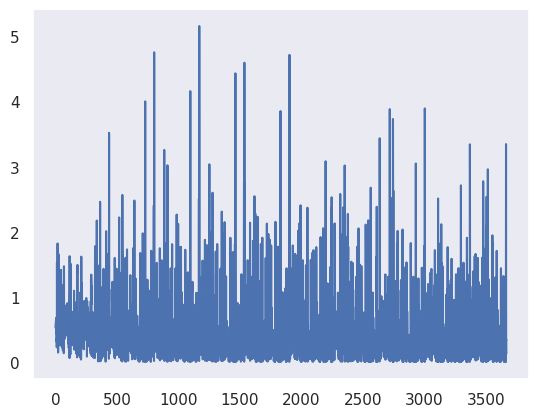

In [13]:
plt.plot(train_losses)

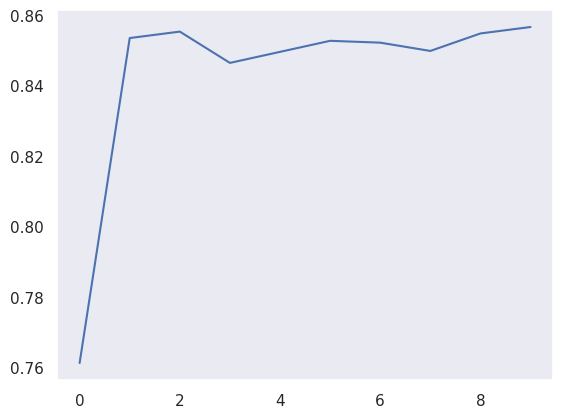

In [14]:
plt.plot(test_accuracy)

In [15]:
model_dir = '../models_physio/'
model_path = f'{model_dir}physio16k_fold3_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3276/3808 (0.8603)
{'acc_detail': tensor([0.5244, 0.9614], device='cuda:0'),
 'acc_unweighted': tensor(0.7429, device='cuda:0'),
 'acc_weighted': tensor(0.8603, device='cuda:0'),
 'f1s_detail': tensor([0.6346, 0.9136], device='cuda:0'),
 'f1s_unweighted': tensor(0.7741, device='cuda:0'),
 'f1s_weighted': tensor(0.8491, device='cuda:0'),
 'precision_detail': tensor([0.8035, 0.8704], device='cuda:0'),
 'recall_detail': tensor([0.5244, 0.9614], device='cuda:0'),
 'rocauc': tensor(0.9003, device='cuda:0'),
 'rocauc_detail': tensor([0.9003, 0.9003], device='cuda:0'),
 'uar': tensor(0.7429, device='cuda:0'),
 'wap': tensor(0.8549, device='cuda:0')}


tensor([[ 462,  419],
        [ 113, 2814]], device='cuda:0')

In [18]:
n_epoch = 10
n_epoch2 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                      | 0.00411522633744856/50 [00:00<1:19:33, 95.48s/it]

Train Epoch: 11 [0/11751 (0%)]	Loss: 0.002527
Mem before-during-after: 17885696 18031616 18508288


  0%|                                                                      | 0.08641975308641978/50 [00:08<1:18:23, 94.23s/it]

Train Epoch: 11 [1280/11751 (11%)]	Loss: 0.017631
Mem before-during-after: 18508288 18653184 18508288


  0%|▏                                                                     | 0.16872427983539084/50 [00:16<1:18:57, 95.08s/it]

Train Epoch: 11 [2560/11751 (22%)]	Loss: 0.225627
Mem before-during-after: 18508288 18653184 18508288


  1%|▎                                                                     | 0.25102880658436166/50 [00:23<1:18:15, 94.39s/it]

Train Epoch: 11 [3840/11751 (33%)]	Loss: 0.020462
Mem before-during-after: 18508288 18653184 18508288


  1%|▍                                                                      | 0.3333333333333325/50 [00:31<1:18:34, 94.92s/it]

Train Epoch: 11 [5120/11751 (44%)]	Loss: 0.239643
Mem before-during-after: 18508288 18653184 18508288


  1%|▌                                                                      | 0.4156378600823033/50 [00:39<1:20:00, 96.81s/it]

Train Epoch: 11 [6400/11751 (54%)]	Loss: 0.133591
Mem before-during-after: 18508288 18653184 18508288


  1%|▋                                                                      | 0.4979423868312741/50 [00:47<1:17:37, 94.10s/it]

Train Epoch: 11 [7680/11751 (65%)]	Loss: 0.267740
Mem before-during-after: 18508288 18653184 18508288


  1%|▊                                                                       | 0.580246913580247/50 [00:55<1:18:11, 94.93s/it]

Train Epoch: 11 [8960/11751 (76%)]	Loss: 0.779206
Mem before-during-after: 18508288 18653184 18508288


  1%|▉                                                                      | 0.6625514403292201/50 [01:02<1:17:19, 94.04s/it]

Train Epoch: 11 [10240/11751 (87%)]	Loss: 0.177603
Mem before-during-after: 18508288 18653184 18508288


  1%|█                                                                      | 0.7448559670781931/50 [01:10<1:17:43, 94.68s/it]

Train Epoch: 11 [11520/11751 (98%)]	Loss: 0.178158
Mem before-during-after: 18508288 18653184 18508288


  2%|█▍                                                                     | 1.0020576131687338/50 [01:34<1:16:20, 93.49s/it]


Test Epoch: 11	Accuracy: 3312/3808 (87%)

Train Epoch: 12 [0/11751 (0%)]	Loss: 0.007913
Mem before-during-after: 18507264 18653184 18508288


  2%|█▌                                                                     | 1.0864197530864266/50 [01:42<1:17:07, 94.60s/it]

Train Epoch: 12 [1280/11751 (11%)]	Loss: 0.008671
Mem before-during-after: 18508288 18653184 18508288


  2%|█▋                                                                     | 1.1687242798353952/50 [01:50<1:17:18, 94.99s/it]

Train Epoch: 12 [2560/11751 (22%)]	Loss: 0.236247
Mem before-during-after: 18508288 18653184 18508288


  3%|█▊                                                                     | 1.2510288065843638/50 [01:58<1:16:40, 94.37s/it]

Train Epoch: 12 [3840/11751 (33%)]	Loss: 0.053515
Mem before-during-after: 18508288 18653184 18508288


  3%|█▉                                                                     | 1.3333333333333324/50 [02:06<1:16:48, 94.71s/it]

Train Epoch: 12 [5120/11751 (44%)]	Loss: 0.248582
Mem before-during-after: 18508288 18653184 18508288


  3%|██                                                                      | 1.415637860082301/50 [02:13<1:16:22, 94.32s/it]

Train Epoch: 12 [6400/11751 (54%)]	Loss: 0.108918
Mem before-during-after: 18508288 18653184 18508288


  3%|██▏                                                                    | 1.4979423868312696/50 [02:21<1:17:13, 95.53s/it]

Train Epoch: 12 [7680/11751 (65%)]	Loss: 0.291190
Mem before-during-after: 18508288 18653184 18508288


  3%|██▏                                                                    | 1.5802469135802382/50 [02:29<1:16:06, 94.30s/it]

Train Epoch: 12 [8960/11751 (76%)]	Loss: 0.934558
Mem before-during-after: 18508288 18653184 18508288


  3%|██▎                                                                    | 1.6625514403292068/50 [02:37<1:16:10, 94.55s/it]

Train Epoch: 12 [10240/11751 (87%)]	Loss: 0.177405
Mem before-during-after: 18508288 18653184 18508288


  3%|██▍                                                                    | 1.7448559670781754/50 [02:45<1:15:57, 94.45s/it]

Train Epoch: 12 [11520/11751 (98%)]	Loss: 0.161796
Mem before-during-after: 18508288 18653184 18508288


  4%|██▊                                                                    | 2.0020576131687022/50 [03:09<1:15:20, 94.19s/it]


Test Epoch: 12	Accuracy: 3312/3808 (87%)

Train Epoch: 13 [0/11751 (0%)]	Loss: 0.007420
Mem before-during-after: 18507264 18653184 18508288


  4%|███                                                                     | 2.086419753086404/50 [03:17<1:15:36, 94.67s/it]

Train Epoch: 13 [1280/11751 (11%)]	Loss: 0.003836
Mem before-during-after: 18508288 18653184 18508288


  4%|███                                                                    | 2.1687242798353816/50 [03:24<1:15:23, 94.56s/it]

Train Epoch: 13 [2560/11751 (22%)]	Loss: 0.193008
Mem before-during-after: 18508288 18653184 18508288


  5%|███▏                                                                    | 2.251028806584359/50 [03:32<1:15:10, 94.45s/it]

Train Epoch: 13 [3840/11751 (33%)]	Loss: 0.059507
Mem before-during-after: 18508288 18653184 18508288


  5%|███▎                                                                   | 2.3333333333333366/50 [03:40<1:14:40, 93.99s/it]

Train Epoch: 13 [5120/11751 (44%)]	Loss: 0.271088
Mem before-during-after: 18508288 18653184 18508288


  5%|███▍                                                                    | 2.415637860082314/50 [03:48<1:14:29, 93.93s/it]

Train Epoch: 13 [6400/11751 (54%)]	Loss: 0.123670
Mem before-during-after: 18508288 18653184 18508288


  5%|███▌                                                                   | 2.4979423868312916/50 [03:56<1:14:22, 93.94s/it]

Train Epoch: 13 [7680/11751 (65%)]	Loss: 0.252577
Mem before-during-after: 18508288 18653184 18508288


  5%|███▋                                                                    | 2.580246913580269/50 [04:03<1:14:35, 94.38s/it]

Train Epoch: 13 [8960/11751 (76%)]	Loss: 1.095456
Mem before-during-after: 18508288 18653184 18508288


  5%|███▊                                                                   | 2.6625514403292465/50 [04:11<1:14:08, 93.97s/it]

Train Epoch: 13 [10240/11751 (87%)]	Loss: 0.153403
Mem before-during-after: 18508288 18653184 18508288


  5%|███▉                                                                    | 2.744855967078224/50 [04:19<1:14:13, 94.23s/it]

Train Epoch: 13 [11520/11751 (98%)]	Loss: 0.128987
Mem before-during-after: 18508288 18653184 18508288


  6%|████▎                                                                  | 3.0020576131687786/50 [04:44<1:14:35, 95.23s/it]


Test Epoch: 13	Accuracy: 3308/3808 (87%)

Train Epoch: 14 [0/11751 (0%)]	Loss: 0.005563
Mem before-during-after: 18507264 18653184 18508288


  6%|████▍                                                                  | 3.0864197530864805/50 [04:52<1:14:28, 95.25s/it]

Train Epoch: 14 [1280/11751 (11%)]	Loss: 0.001930
Mem before-during-after: 18508288 18653184 18508288


  6%|████▌                                                                   | 3.168724279835458/50 [04:59<1:13:52, 94.65s/it]

Train Epoch: 14 [2560/11751 (22%)]	Loss: 0.161044
Mem before-during-after: 18508288 18653184 18508288


  6%|████▋                                                                   | 3.248971193415711/50 [05:07<1:13:35, 94.44s/it]

Train Epoch: 14 [3840/11751 (33%)]	Loss: 0.060885
Mem before-during-after: 18508288 18653184 18508288


  7%|████▋                                                                  | 3.3312757201646885/50 [05:15<1:14:13, 95.44s/it]

Train Epoch: 14 [5120/11751 (44%)]	Loss: 0.296609
Mem before-during-after: 18508288 18653184 18508288


  7%|████▊                                                                  | 3.4156378600823905/50 [05:23<1:14:30, 95.96s/it]

Train Epoch: 14 [6400/11751 (54%)]	Loss: 0.140978
Mem before-during-after: 18508288 18653184 18508288


  7%|█████                                                                   | 3.497942386831368/50 [05:31<1:14:08, 95.67s/it]

Train Epoch: 14 [7680/11751 (65%)]	Loss: 0.228701
Mem before-during-after: 18508288 18653184 18508288


  7%|█████                                                                  | 3.5802469135803454/50 [05:39<1:14:41, 96.54s/it]

Train Epoch: 14 [8960/11751 (76%)]	Loss: 1.088722
Mem before-during-after: 18508288 18653184 18508288


  7%|█████▎                                                                  | 3.662551440329323/50 [05:47<1:12:51, 94.35s/it]

Train Epoch: 14 [10240/11751 (87%)]	Loss: 0.149191
Mem before-during-after: 18508288 18653184 18508288


  7%|█████▍                                                                  | 3.742798353909576/50 [05:55<1:15:56, 98.50s/it]

Train Epoch: 14 [11520/11751 (98%)]	Loss: 0.144226
Mem before-during-after: 18508288 18653184 18508288


  8%|█████▊                                                                  | 4.002057613168855/50 [06:19<1:14:04, 96.62s/it]


Test Epoch: 14	Accuracy: 3329/3808 (87%)

Train Epoch: 15 [0/11751 (0%)]	Loss: 0.005852
Mem before-during-after: 18507264 18653184 18508288


  8%|█████▉                                                                  | 4.086419753086557/50 [06:27<1:12:39, 94.94s/it]

Train Epoch: 15 [1280/11751 (11%)]	Loss: 0.002151
Mem before-during-after: 18508288 18653184 18508288


  8%|██████                                                                  | 4.168724279835534/50 [06:35<1:11:46, 93.95s/it]

Train Epoch: 15 [2560/11751 (22%)]	Loss: 0.146329
Mem before-during-after: 18508288 18653184 18508288


  9%|██████                                                                  | 4.251028806584512/50 [06:43<1:11:30, 93.78s/it]

Train Epoch: 15 [3840/11751 (33%)]	Loss: 0.058582
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▏                                                                 | 4.333333333333489/50 [06:51<1:11:17, 93.67s/it]

Train Epoch: 15 [5120/11751 (44%)]	Loss: 0.291997
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▎                                                                 | 4.415637860082467/50 [06:58<1:11:08, 93.64s/it]

Train Epoch: 15 [6400/11751 (54%)]	Loss: 0.154190
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▍                                                                 | 4.497942386831444/50 [07:06<1:11:16, 93.99s/it]

Train Epoch: 15 [7680/11751 (65%)]	Loss: 0.262379
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▌                                                                 | 4.580246913580422/50 [07:14<1:11:07, 93.95s/it]

Train Epoch: 15 [8960/11751 (76%)]	Loss: 1.191618
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▋                                                                 | 4.662551440329399/50 [07:22<1:11:12, 94.23s/it]

Train Epoch: 15 [10240/11751 (87%)]	Loss: 0.168296
Mem before-during-after: 18508288 18653184 18508288


  9%|██████▊                                                                 | 4.744855967078377/50 [07:30<1:10:45, 93.81s/it]

Train Epoch: 15 [11520/11751 (98%)]	Loss: 0.126855
Mem before-during-after: 18508288 18653184 18508288


 10%|███████▏                                                                | 5.002057613168931/50 [07:54<1:10:05, 93.46s/it]


Test Epoch: 15	Accuracy: 3330/3808 (87%)

Train Epoch: 16 [0/11751 (0%)]	Loss: 0.004988
Mem before-during-after: 18507264 18653184 18508288


 10%|███████▎                                                                | 5.086419753086633/50 [08:02<1:10:43, 94.49s/it]

Train Epoch: 16 [1280/11751 (11%)]	Loss: 0.001218
Mem before-during-after: 18508288 18653184 18508288


 10%|███████▍                                                                | 5.168724279835611/50 [08:09<1:10:06, 93.82s/it]

Train Epoch: 16 [2560/11751 (22%)]	Loss: 0.160168
Mem before-during-after: 18508288 18653184 18508288


 11%|███████▌                                                                | 5.251028806584588/50 [08:17<1:09:57, 93.80s/it]

Train Epoch: 16 [3840/11751 (33%)]	Loss: 0.054735
Mem before-during-after: 18508288 18653184 18508288


 11%|███████▋                                                                | 5.333333333333566/50 [08:25<1:10:03, 94.11s/it]

Train Epoch: 16 [5120/11751 (44%)]	Loss: 0.296546
Mem before-during-after: 18508288 18653184 18508288


 11%|███████▊                                                                | 5.415637860082543/50 [08:33<1:10:23, 94.73s/it]

Train Epoch: 16 [6400/11751 (54%)]	Loss: 0.185774
Mem before-during-after: 18508288 18653184 18508288


 11%|███████▉                                                                | 5.497942386831521/50 [08:41<1:09:58, 94.34s/it]

Train Epoch: 16 [7680/11751 (65%)]	Loss: 0.280288
Mem before-during-after: 18508288 18653184 18508288


 11%|████████                                                                | 5.580246913580498/50 [08:48<1:10:01, 94.58s/it]

Train Epoch: 16 [8960/11751 (76%)]	Loss: 1.151400
Mem before-during-after: 18508288 18653184 18508288


 11%|████████▏                                                               | 5.662551440329476/50 [08:56<1:10:18, 95.15s/it]

Train Epoch: 16 [10240/11751 (87%)]	Loss: 0.156314
Mem before-during-after: 18508288 18653184 18508288


 11%|████████▎                                                               | 5.744855967078453/50 [09:04<1:09:25, 94.12s/it]

Train Epoch: 16 [11520/11751 (98%)]	Loss: 0.075785
Mem before-during-after: 18508288 18653184 18508288


 12%|████████▋                                                               | 6.002057613169008/50 [09:28<1:09:32, 94.83s/it]


Test Epoch: 16	Accuracy: 3331/3808 (87%)

Train Epoch: 17 [0/11751 (0%)]	Loss: 0.003649
Mem before-during-after: 18507264 18653184 18508288


 12%|████████▉                                                                | 6.08641975308671/50 [09:36<1:09:08, 94.46s/it]

Train Epoch: 17 [1280/11751 (11%)]	Loss: 0.001043
Mem before-during-after: 18508288 18653184 18508288


 12%|████████▉                                                               | 6.168724279835687/50 [09:44<1:09:08, 94.65s/it]

Train Epoch: 17 [2560/11751 (22%)]	Loss: 0.151225
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████                                                               | 6.251028806584665/50 [09:52<1:08:58, 94.59s/it]

Train Epoch: 17 [3840/11751 (33%)]	Loss: 0.044835
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████                                                               | 6.333333333333642/50 [10:00<1:08:29, 94.12s/it]

Train Epoch: 17 [5120/11751 (44%)]	Loss: 0.297756
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████▎                                                               | 6.41563786008262/50 [10:07<1:08:27, 94.24s/it]

Train Epoch: 17 [6400/11751 (54%)]	Loss: 0.154417
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████▎                                                              | 6.497942386831597/50 [10:15<1:09:00, 95.19s/it]

Train Epoch: 17 [7680/11751 (65%)]	Loss: 0.323365
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████▍                                                              | 6.580246913580575/50 [10:23<1:08:41, 94.93s/it]

Train Epoch: 17 [8960/11751 (76%)]	Loss: 1.564463
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████▌                                                              | 6.662551440329552/50 [10:31<1:08:31, 94.87s/it]

Train Epoch: 17 [10240/11751 (87%)]	Loss: 0.190149
Mem before-during-after: 18508288 18653184 18508288


 13%|█████████▌                                                             | 6.7448559670785295/50 [10:39<1:07:57, 94.27s/it]

Train Epoch: 17 [11520/11751 (98%)]	Loss: 0.080281
Mem before-during-after: 18508288 18653184 18508288


 14%|██████████                                                              | 7.002057613169084/50 [11:03<1:07:58, 94.85s/it]


Test Epoch: 17	Accuracy: 3357/3808 (88%)

Train Epoch: 18 [0/11751 (0%)]	Loss: 0.003322
Mem before-during-after: 18507264 18653184 18508288


 14%|██████████▏                                                             | 7.086419753086786/50 [11:11<1:08:23, 95.62s/it]

Train Epoch: 18 [1280/11751 (11%)]	Loss: 0.000775
Mem before-during-after: 18508288 18653184 18508288


 14%|██████████▏                                                            | 7.1687242798357635/50 [11:19<1:07:24, 94.43s/it]

Train Epoch: 18 [2560/11751 (22%)]	Loss: 0.168026
Mem before-during-after: 18508288 18653184 18508288


 15%|██████████▍                                                             | 7.251028806584741/50 [11:26<1:07:41, 95.01s/it]

Train Epoch: 18 [3840/11751 (33%)]	Loss: 0.037149
Mem before-during-after: 18508288 18653184 18508288


 15%|██████████▍                                                            | 7.3333333333337185/50 [11:34<1:07:44, 95.26s/it]

Train Epoch: 18 [5120/11751 (44%)]	Loss: 0.280287
Mem before-during-after: 18508288 18653184 18508288


 15%|██████████▋                                                             | 7.415637860082696/50 [11:42<1:06:38, 93.90s/it]

Train Epoch: 18 [6400/11751 (54%)]	Loss: 0.101866
Mem before-during-after: 18508288 18653184 18508288


 15%|██████████▋                                                            | 7.4979423868316735/50 [11:50<1:07:10, 94.84s/it]

Train Epoch: 18 [7680/11751 (65%)]	Loss: 0.390850
Mem before-during-after: 18508288 18653184 18508288


 15%|██████████▉                                                             | 7.580246913580651/50 [11:58<1:07:56, 96.11s/it]

Train Epoch: 18 [8960/11751 (76%)]	Loss: 1.418905
Mem before-during-after: 18508288 18653184 18508288


 15%|███████████                                                             | 7.662551440329628/50 [12:06<1:08:08, 96.56s/it]

Train Epoch: 18 [10240/11751 (87%)]	Loss: 0.221752
Mem before-during-after: 18508288 18653184 18508288


 15%|███████████▏                                                            | 7.744855967078606/50 [12:13<1:06:19, 94.17s/it]

Train Epoch: 18 [11520/11751 (98%)]	Loss: 0.069153
Mem before-during-after: 18508288 18653184 18508288


 16%|███████████▌                                                            | 8.002057613169159/50 [12:37<1:08:07, 97.33s/it]


Test Epoch: 18	Accuracy: 3368/3808 (88%)

Train Epoch: 19 [0/11751 (0%)]	Loss: 0.002380
Mem before-during-after: 18507264 18653184 18508288


 16%|███████████▋                                                            | 8.086419753086824/50 [12:45<1:05:52, 94.31s/it]

Train Epoch: 19 [1280/11751 (11%)]	Loss: 0.000718
Mem before-during-after: 18508288 18653184 18508288


 16%|███████████▊                                                            | 8.168724279835766/50 [12:53<1:05:37, 94.13s/it]

Train Epoch: 19 [2560/11751 (22%)]	Loss: 0.143434
Mem before-during-after: 18508288 18653184 18508288


 17%|███████████▉                                                            | 8.251028806584708/50 [13:01<1:06:46, 95.96s/it]

Train Epoch: 19 [3840/11751 (33%)]	Loss: 0.024325
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████▏                                                            | 8.33333333333365/50 [13:09<1:06:39, 95.98s/it]

Train Epoch: 19 [5120/11751 (44%)]	Loss: 0.282095
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████                                                            | 8.415637860082592/50 [13:17<1:06:07, 95.42s/it]

Train Epoch: 19 [6400/11751 (54%)]	Loss: 0.102089
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████▏                                                           | 8.497942386831534/50 [13:25<1:06:45, 96.52s/it]

Train Epoch: 19 [7680/11751 (65%)]	Loss: 0.431427
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████▎                                                           | 8.580246913580476/50 [13:32<1:05:18, 94.61s/it]

Train Epoch: 19 [8960/11751 (76%)]	Loss: 1.165033
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████▍                                                           | 8.662551440329418/50 [13:40<1:04:57, 94.28s/it]

Train Epoch: 19 [10240/11751 (87%)]	Loss: 0.217075
Mem before-during-after: 18508288 18653184 18508288


 17%|████████████▊                                                            | 8.74485596707836/50 [13:48<1:04:53, 94.37s/it]

Train Epoch: 19 [11520/11751 (98%)]	Loss: 0.044952
Mem before-during-after: 18508288 18653184 18508288


 18%|████████████▉                                                           | 9.002057613168803/50 [14:12<1:04:51, 94.91s/it]


Test Epoch: 19	Accuracy: 3372/3808 (88%)

Train Epoch: 20 [0/11751 (0%)]	Loss: 0.004426
Mem before-during-after: 18507264 18653184 18508288


 18%|█████████████                                                           | 9.086419753086469/50 [14:20<1:03:58, 93.81s/it]

Train Epoch: 20 [1280/11751 (11%)]	Loss: 0.000698
Mem before-during-after: 18508288 18653184 18508288


 18%|█████████████▏                                                          | 9.168724279835411/50 [14:28<1:05:00, 95.52s/it]

Train Epoch: 20 [2560/11751 (22%)]	Loss: 0.149177
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▎                                                          | 9.251028806584353/50 [14:36<1:04:14, 94.59s/it]

Train Epoch: 20 [3840/11751 (33%)]	Loss: 0.027205
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▍                                                          | 9.333333333333295/50 [14:43<1:03:48, 94.13s/it]

Train Epoch: 20 [5120/11751 (44%)]	Loss: 0.272797
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▌                                                          | 9.415637860082237/50 [14:51<1:03:52, 94.43s/it]

Train Epoch: 20 [6400/11751 (54%)]	Loss: 0.060993
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▋                                                          | 9.497942386831179/50 [14:59<1:03:17, 93.77s/it]

Train Epoch: 20 [7680/11751 (65%)]	Loss: 0.471434
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▉                                                           | 9.58024691358012/50 [15:07<1:03:36, 94.42s/it]

Train Epoch: 20 [8960/11751 (76%)]	Loss: 1.137937
Mem before-during-after: 18508288 18653184 18508288


 19%|█████████████▉                                                          | 9.662551440329063/50 [15:15<1:03:14, 94.06s/it]

Train Epoch: 20 [10240/11751 (87%)]	Loss: 0.223713
Mem before-during-after: 18508288 18653184 18508288


 19%|██████████████                                                          | 9.744855967078005/50 [15:22<1:04:35, 96.28s/it]

Train Epoch: 20 [11520/11751 (98%)]	Loss: 0.035667
Mem before-during-after: 18508288 18653184 18508288


 20%|██████████████▏                                                        | 10.002057613168448/50 [15:46<1:02:22, 93.56s/it]


Test Epoch: 20	Accuracy: 3363/3808 (88%)

Train Epoch: 21 [0/11751 (0%)]	Loss: 0.005405
Mem before-during-after: 18507264 18653184 18508288


 20%|██████████████▎                                                        | 10.086419753086114/50 [15:54<1:04:10, 96.48s/it]

Train Epoch: 21 [1280/11751 (11%)]	Loss: 0.000980
Mem before-during-after: 18508288 18653184 18508288


 20%|██████████████▍                                                        | 10.168724279835056/50 [16:02<1:03:17, 95.34s/it]

Train Epoch: 21 [2560/11751 (22%)]	Loss: 0.153306
Mem before-during-after: 18508288 18653184 18508288


 21%|██████████████▌                                                        | 10.251028806583998/50 [16:10<1:02:38, 94.55s/it]

Train Epoch: 21 [3840/11751 (33%)]	Loss: 0.017140
Mem before-during-after: 18508288 18653184 18508288


 21%|██████████████▉                                                         | 10.33333333333294/50 [16:18<1:02:07, 93.98s/it]

Train Epoch: 21 [5120/11751 (44%)]	Loss: 0.284994
Mem before-during-after: 18508288 18653184 18508288


 21%|██████████████▌                                                       | 10.415637860081882/50 [16:26<1:06:59, 101.54s/it]

Train Epoch: 21 [6400/11751 (54%)]	Loss: 0.056403
Mem before-during-after: 18508288 18653184 18508288


 21%|██████████████▉                                                        | 10.497942386830823/50 [16:34<1:02:49, 95.43s/it]

Train Epoch: 21 [7680/11751 (65%)]	Loss: 0.486600
Mem before-during-after: 18508288 18653184 18508288


 21%|███████████████                                                        | 10.580246913579765/50 [16:41<1:01:58, 94.33s/it]

Train Epoch: 21 [8960/11751 (76%)]	Loss: 1.152664
Mem before-during-after: 18508288 18653184 18508288


 21%|███████████████▏                                                       | 10.662551440328707/50 [16:49<1:01:51, 94.35s/it]

Train Epoch: 21 [10240/11751 (87%)]	Loss: 0.232682
Mem before-during-after: 18508288 18653184 18508288


 21%|███████████████▍                                                        | 10.74485596707765/50 [16:57<1:02:05, 94.91s/it]

Train Epoch: 21 [11520/11751 (98%)]	Loss: 0.062542
Mem before-during-after: 18508288 18653184 18508288


 22%|███████████████▌                                                       | 11.002057613168093/50 [17:21<1:01:00, 93.88s/it]


Test Epoch: 21	Accuracy: 3374/3808 (88%)

Train Epoch: 22 [0/11751 (0%)]	Loss: 0.003533
Mem before-during-after: 18507264 18653184 18508288


 22%|███████████████▋                                                       | 11.086419753085758/50 [17:29<1:01:35, 94.96s/it]

Train Epoch: 22 [1280/11751 (11%)]	Loss: 0.001454
Mem before-during-after: 18508288 18653184 18508288


 22%|████████████████▎                                                        | 11.1687242798347/50 [17:37<1:01:04, 94.37s/it]

Train Epoch: 22 [2560/11751 (22%)]	Loss: 0.200407
Mem before-during-after: 18508288 18653184 18508288


 23%|███████████████▉                                                       | 11.251028806583642/50 [17:45<1:00:49, 94.17s/it]

Train Epoch: 22 [3840/11751 (33%)]	Loss: 0.016972
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████                                                       | 11.333333333332584/50 [17:53<1:01:14, 95.02s/it]

Train Epoch: 22 [5120/11751 (44%)]	Loss: 0.290369
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████▏                                                      | 11.415637860081526/50 [18:01<1:00:29, 94.06s/it]

Train Epoch: 22 [6400/11751 (54%)]	Loss: 0.040324
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████▎                                                      | 11.495884773661745/50 [18:08<1:01:05, 95.20s/it]

Train Epoch: 22 [7680/11751 (65%)]	Loss: 0.566934
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████▋                                                       | 11.58024691357941/50 [18:16<1:00:50, 95.01s/it]

Train Epoch: 22 [8960/11751 (76%)]	Loss: 1.381510
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████▌                                                      | 11.662551440328352/50 [18:24<1:01:18, 95.94s/it]

Train Epoch: 22 [10240/11751 (87%)]	Loss: 0.235640
Mem before-during-after: 18508288 18653184 18508288


 23%|████████████████▋                                                      | 11.744855967077294/50 [18:32<1:00:52, 95.48s/it]

Train Epoch: 22 [11520/11751 (98%)]	Loss: 0.076614
Mem before-during-after: 18508288 18653184 18508288


 24%|█████████████████▌                                                       | 12.002057613167738/50 [18:56<59:46, 94.39s/it]


Test Epoch: 22	Accuracy: 3364/3808 (88%)

Train Epoch: 23 [0/11751 (0%)]	Loss: 0.002333
Mem before-during-after: 18507264 18653184 18508288


 24%|█████████████████▏                                                     | 12.086419753085403/50 [19:04<1:00:33, 95.84s/it]

Train Epoch: 23 [1280/11751 (11%)]	Loss: 0.000599
Mem before-during-after: 18508288 18653184 18508288


 24%|█████████████████▎                                                     | 12.166666666665622/50 [19:12<1:00:52, 96.53s/it]

Train Epoch: 23 [2560/11751 (22%)]	Loss: 0.111981
Mem before-during-after: 18508288 18653184 18508288


 25%|█████████████████▍                                                     | 12.251028806583287/50 [19:20<1:01:05, 97.11s/it]

Train Epoch: 23 [3840/11751 (33%)]	Loss: 0.040164
Mem before-during-after: 18508288 18653184 18508288


 25%|██████████████████                                                       | 12.331275720163505/50 [19:28<59:34, 94.90s/it]

Train Epoch: 23 [5120/11751 (44%)]	Loss: 0.319639
Mem before-during-after: 18508288 18653184 18508288


 25%|█████████████████▋                                                     | 12.415637860081171/50 [19:36<1:00:03, 95.87s/it]

Train Epoch: 23 [6400/11751 (54%)]	Loss: 0.020095
Mem before-during-after: 18508288 18653184 18508288


 25%|█████████████████▉                                                      | 12.49588477366139/50 [19:44<1:00:54, 97.44s/it]

Train Epoch: 23 [7680/11751 (65%)]	Loss: 0.510484
Mem before-during-after: 18508288 18653184 18508288


 25%|██████████████████▎                                                      | 12.580246913579055/50 [19:52<59:44, 95.80s/it]

Train Epoch: 23 [8960/11751 (76%)]	Loss: 1.456123
Mem before-during-after: 18508288 18653184 18508288


 25%|██████████████████▍                                                      | 12.660493827159273/50 [20:00<58:27, 93.94s/it]

Train Epoch: 23 [10240/11751 (87%)]	Loss: 0.259133
Mem before-during-after: 18508288 18653184 18508288


 25%|██████████████████                                                     | 12.744855967076939/50 [20:08<1:00:02, 96.70s/it]

Train Epoch: 23 [11520/11751 (98%)]	Loss: 0.036517
Mem before-during-after: 18508288 18653184 18508288


 26%|██████████████████▉                                                      | 13.002057613167382/50 [20:32<57:23, 93.08s/it]


Test Epoch: 23	Accuracy: 3373/3808 (88%)

Train Epoch: 24 [0/11751 (0%)]	Loss: 0.002869
Mem before-during-after: 18507264 18653184 18508288


 26%|███████████████████                                                      | 13.086419753085048/50 [20:40<57:58, 94.24s/it]

Train Epoch: 24 [1280/11751 (11%)]	Loss: 0.002212
Mem before-during-after: 18508288 18653184 18508288


 26%|███████████████████▍                                                      | 13.16872427983399/50 [20:48<57:39, 93.92s/it]

Train Epoch: 24 [2560/11751 (22%)]	Loss: 0.106169
Mem before-during-after: 18508288 18653184 18508288


 27%|███████████████████▎                                                     | 13.251028806582932/50 [20:55<57:32, 93.96s/it]

Train Epoch: 24 [3840/11751 (33%)]	Loss: 0.027154
Mem before-during-after: 18508288 18653184 18508288


 27%|███████████████████▍                                                     | 13.333333333331874/50 [21:03<57:18, 93.78s/it]

Train Epoch: 24 [5120/11751 (44%)]	Loss: 0.338832
Mem before-during-after: 18508288 18653184 18508288


 27%|███████████████████▌                                                     | 13.415637860080816/50 [21:11<57:16, 93.93s/it]

Train Epoch: 24 [6400/11751 (54%)]	Loss: 0.006412
Mem before-during-after: 18508288 18653184 18508288


 27%|███████████████████▋                                                     | 13.497942386829758/50 [21:19<57:38, 94.74s/it]

Train Epoch: 24 [7680/11751 (65%)]	Loss: 0.552774
Mem before-during-after: 18508288 18653184 18508288


 27%|████████████████████▎                                                      | 13.5802469135787/50 [21:26<57:55, 95.42s/it]

Train Epoch: 24 [8960/11751 (76%)]	Loss: 1.612033
Mem before-during-after: 18508288 18653184 18508288


 27%|███████████████████▉                                                     | 13.662551440327642/50 [21:34<57:28, 94.90s/it]

Train Epoch: 24 [10240/11751 (87%)]	Loss: 0.273147
Mem before-during-after: 18508288 18653184 18508288


 27%|████████████████████                                                     | 13.744855967076584/50 [21:42<57:10, 94.63s/it]

Train Epoch: 24 [11520/11751 (98%)]	Loss: 0.060759
Mem before-during-after: 18508288 18653184 18508288


 28%|████████████████████▍                                                    | 14.002057613167027/50 [22:06<56:15, 93.77s/it]


Test Epoch: 24	Accuracy: 3381/3808 (88%)

Train Epoch: 25 [0/11751 (0%)]	Loss: 0.005979
Mem before-during-after: 18507264 18653184 18508288


 28%|████████████████████▌                                                    | 14.086419753084693/50 [22:14<56:46, 94.85s/it]

Train Epoch: 25 [1280/11751 (11%)]	Loss: 0.001862
Mem before-during-after: 18508288 18653184 18508288


 28%|████████████████████▋                                                    | 14.168724279833635/50 [22:22<59:29, 99.61s/it]

Train Epoch: 25 [2560/11751 (22%)]	Loss: 0.129618
Mem before-during-after: 18508288 18653184 18508288


 29%|████████████████████▊                                                    | 14.251028806582577/50 [22:30<56:29, 94.83s/it]

Train Epoch: 25 [3840/11751 (33%)]	Loss: 0.015725
Mem before-during-after: 18508288 18653184 18508288


 29%|████████████████████▉                                                    | 14.333333333331518/50 [22:38<56:14, 94.60s/it]

Train Epoch: 25 [5120/11751 (44%)]	Loss: 0.328319
Mem before-during-after: 18508288 18653184 18508288


 29%|█████████████████████▎                                                    | 14.41563786008046/50 [22:46<55:58, 94.37s/it]

Train Epoch: 25 [6400/11751 (54%)]	Loss: 0.004495
Mem before-during-after: 18508288 18653184 18508288


 29%|█████████████████████▏                                                   | 14.497942386829402/50 [22:53<56:53, 96.15s/it]

Train Epoch: 25 [7680/11751 (65%)]	Loss: 0.491398
Mem before-during-after: 18508288 18653184 18508288


 29%|█████████████████████▎                                                   | 14.580246913578344/50 [23:01<55:33, 94.10s/it]

Train Epoch: 25 [8960/11751 (76%)]	Loss: 1.560999
Mem before-during-after: 18508288 18653184 18508288


 29%|█████████████████████▍                                                   | 14.662551440327286/50 [23:09<55:48, 94.75s/it]

Train Epoch: 25 [10240/11751 (87%)]	Loss: 0.247974
Mem before-during-after: 18508288 18653184 18508288


 29%|█████████████████████▌                                                   | 14.744855967076228/50 [23:17<55:12, 93.95s/it]

Train Epoch: 25 [11520/11751 (98%)]	Loss: 0.046746
Mem before-during-after: 18508288 18653184 18508288


 30%|█████████████████████▉                                                   | 15.002057613166672/50 [23:41<54:38, 93.67s/it]


Test Epoch: 25	Accuracy: 3364/3808 (88%)

Train Epoch: 26 [0/11751 (0%)]	Loss: 0.004012
Mem before-during-after: 18507264 18653184 18508288


 30%|██████████████████████                                                   | 15.086419753084337/50 [23:49<54:40, 93.97s/it]

Train Epoch: 26 [1280/11751 (11%)]	Loss: 0.001162
Mem before-during-after: 18508288 18653184 18508288


 30%|██████████████████████▍                                                   | 15.16872427983328/50 [23:57<54:54, 94.58s/it]

Train Epoch: 26 [2560/11751 (22%)]	Loss: 0.126332
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▎                                                  | 15.251028806582221/50 [24:05<54:41, 94.45s/it]

Train Epoch: 26 [3840/11751 (33%)]	Loss: 0.012774
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▍                                                  | 15.333333333331163/50 [24:12<55:15, 95.64s/it]

Train Epoch: 26 [5120/11751 (44%)]	Loss: 0.329629
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▌                                                  | 15.413580246911382/50 [24:20<55:08, 95.67s/it]

Train Epoch: 26 [6400/11751 (54%)]	Loss: 0.003092
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▋                                                  | 15.497942386829047/50 [24:28<54:42, 95.13s/it]

Train Epoch: 26 [7680/11751 (65%)]	Loss: 0.471807
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▋                                                  | 15.580246913577989/50 [24:36<55:09, 96.14s/it]

Train Epoch: 26 [8960/11751 (76%)]	Loss: 2.152948
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▊                                                  | 15.662551440326931/50 [24:44<54:32, 95.30s/it]

Train Epoch: 26 [10240/11751 (87%)]	Loss: 0.213868
Mem before-during-after: 18508288 18653184 18508288


 31%|██████████████████████▉                                                  | 15.744855967075873/50 [24:52<54:31, 95.51s/it]

Train Epoch: 26 [11520/11751 (98%)]	Loss: 0.028154
Mem before-during-after: 18508288 18653184 18508288


 32%|███████████████████████▋                                                  | 16.00205761316632/50 [25:16<53:25, 94.27s/it]


Test Epoch: 26	Accuracy: 3400/3808 (89%)

Train Epoch: 27 [0/11751 (0%)]	Loss: 0.005427
Mem before-during-after: 18507264 18653184 18508288


 32%|███████████████████████▍                                                 | 16.086419753083984/50 [25:24<53:36, 94.83s/it]

Train Epoch: 27 [1280/11751 (11%)]	Loss: 0.002024
Mem before-during-after: 18508288 18653184 18508288


 32%|███████████████████████▌                                                 | 16.168724279832926/50 [25:32<53:03, 94.10s/it]

Train Epoch: 27 [2560/11751 (22%)]	Loss: 0.092081
Mem before-during-after: 18508288 18653184 18508288


 33%|███████████████████████▋                                                 | 16.251028806581868/50 [25:39<53:04, 94.37s/it]

Train Epoch: 27 [3840/11751 (33%)]	Loss: 0.004453
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████▏                                                 | 16.33333333333081/50 [25:47<53:09, 94.74s/it]

Train Epoch: 27 [5120/11751 (44%)]	Loss: 0.369390
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████▎                                                 | 16.41563786007975/50 [25:55<53:25, 95.46s/it]

Train Epoch: 27 [6400/11751 (54%)]	Loss: 0.004528
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████                                                 | 16.497942386828694/50 [26:03<52:59, 94.89s/it]

Train Epoch: 27 [7680/11751 (65%)]	Loss: 0.431749
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████▏                                                | 16.580246913577636/50 [26:11<52:30, 94.29s/it]

Train Epoch: 27 [8960/11751 (76%)]	Loss: 2.284111
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████▎                                                | 16.662551440326578/50 [26:19<52:28, 94.46s/it]

Train Epoch: 27 [10240/11751 (87%)]	Loss: 0.232063
Mem before-during-after: 18508288 18653184 18508288


 33%|████████████████████████▊                                                 | 16.74485596707552/50 [26:26<52:34, 94.85s/it]

Train Epoch: 27 [11520/11751 (98%)]	Loss: 0.036498
Mem before-during-after: 18508288 18653184 18508288


 34%|████████████████████████▊                                                | 17.002057613165963/50 [26:51<52:12, 94.94s/it]


Test Epoch: 27	Accuracy: 3347/3808 (88%)

Train Epoch: 28 [0/11751 (0%)]	Loss: 0.002973
Mem before-during-after: 18507264 18653184 18508288


 34%|█████████████████████████▎                                                | 17.08641975308363/50 [26:59<51:42, 94.26s/it]

Train Epoch: 28 [1280/11751 (11%)]	Loss: 0.002452
Mem before-during-after: 18508288 18653184 18508288


 34%|█████████████████████████▍                                                | 17.16872427983257/50 [27:06<51:34, 94.26s/it]

Train Epoch: 28 [2560/11751 (22%)]	Loss: 0.130128
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▏                                               | 17.251028806581512/50 [27:14<51:33, 94.46s/it]

Train Epoch: 28 [3840/11751 (33%)]	Loss: 0.015925
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▎                                               | 17.333333333330454/50 [27:22<51:27, 94.52s/it]

Train Epoch: 28 [5120/11751 (44%)]	Loss: 0.351489
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▍                                               | 17.415637860079396/50 [27:30<51:59, 95.73s/it]

Train Epoch: 28 [6400/11751 (54%)]	Loss: 0.001765
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▉                                                | 17.49794238682834/50 [27:38<50:46, 93.72s/it]

Train Epoch: 28 [7680/11751 (65%)]	Loss: 0.428706
Mem before-during-after: 18508288 18653184 18508288


 35%|██████████████████████████                                                | 17.58024691357728/50 [27:45<51:06, 94.59s/it]

Train Epoch: 28 [8960/11751 (76%)]	Loss: 2.244203
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▊                                               | 17.662551440326222/50 [27:53<50:47, 94.23s/it]

Train Epoch: 28 [10240/11751 (87%)]	Loss: 0.203228
Mem before-during-after: 18508288 18653184 18508288


 35%|█████████████████████████▉                                               | 17.744855967075164/50 [28:01<50:45, 94.40s/it]

Train Epoch: 28 [11520/11751 (98%)]	Loss: 0.034964
Mem before-during-after: 18508288 18653184 18508288


 36%|██████████████████████████▎                                              | 18.002057613165608/50 [28:25<50:17, 94.30s/it]


Test Epoch: 28	Accuracy: 3366/3808 (88%)

Train Epoch: 29 [0/11751 (0%)]	Loss: 0.007598
Mem before-during-after: 18507264 18653184 18508288


 36%|██████████████████████████▍                                              | 18.086419753083273/50 [28:33<50:22, 94.69s/it]

Train Epoch: 29 [1280/11751 (11%)]	Loss: 0.001733
Mem before-during-after: 18508288 18653184 18508288


 36%|██████████████████████████▌                                              | 18.168724279832215/50 [28:41<50:13, 94.66s/it]

Train Epoch: 29 [2560/11751 (22%)]	Loss: 0.153924
Mem before-during-after: 18508288 18653184 18508288


 37%|██████████████████████████▋                                              | 18.251028806581157/50 [28:49<50:52, 96.16s/it]

Train Epoch: 29 [3840/11751 (33%)]	Loss: 0.015809
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████▍                                               | 18.3333333333301/50 [28:57<49:52, 94.50s/it]

Train Epoch: 29 [5120/11751 (44%)]	Loss: 0.258098
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████▎                                              | 18.41563786007904/50 [29:04<49:30, 94.04s/it]

Train Epoch: 29 [6400/11751 (54%)]	Loss: 0.001221
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████                                              | 18.497942386827983/50 [29:12<49:23, 94.07s/it]

Train Epoch: 29 [7680/11751 (65%)]	Loss: 0.433346
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████▏                                             | 18.580246913576925/50 [29:20<49:25, 94.40s/it]

Train Epoch: 29 [8960/11751 (76%)]	Loss: 2.398496
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████▏                                             | 18.662551440325867/50 [29:28<49:03, 93.93s/it]

Train Epoch: 29 [10240/11751 (87%)]	Loss: 0.229734
Mem before-during-after: 18508288 18653184 18508288


 37%|███████████████████████████▋                                              | 18.74485596707481/50 [29:35<49:18, 94.66s/it]

Train Epoch: 29 [11520/11751 (98%)]	Loss: 0.029594
Mem before-during-after: 18508288 18653184 18508288


 38%|███████████████████████████▎                                            | 19.002057613165253/50 [30:00<51:56, 100.53s/it]


Test Epoch: 29	Accuracy: 3378/3808 (88%)

Train Epoch: 30 [0/11751 (0%)]	Loss: 0.004788
Mem before-during-after: 18507264 18653184 18508288


 38%|███████████████████████████▊                                             | 19.086419753082918/50 [30:08<49:14, 95.58s/it]

Train Epoch: 30 [1280/11751 (11%)]	Loss: 0.003163
Mem before-during-after: 18508288 18653184 18508288


 38%|████████████████████████████▎                                             | 19.16872427983186/50 [30:16<48:26, 94.26s/it]

Train Epoch: 30 [2560/11751 (22%)]	Loss: 0.139713
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████                                             | 19.251028806580802/50 [30:23<48:40, 94.99s/it]

Train Epoch: 30 [3840/11751 (33%)]	Loss: 0.013491
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████▌                                             | 19.33127572016102/50 [30:31<48:46, 95.43s/it]

Train Epoch: 30 [5120/11751 (44%)]	Loss: 0.290489
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████▎                                            | 19.415637860078686/50 [30:39<48:12, 94.58s/it]

Train Epoch: 30 [6400/11751 (54%)]	Loss: 0.000953
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████▍                                            | 19.497942386827628/50 [30:47<48:16, 94.97s/it]

Train Epoch: 30 [7680/11751 (65%)]	Loss: 0.416045
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████▉                                             | 19.58024691357657/50 [30:54<47:42, 94.09s/it]

Train Epoch: 30 [8960/11751 (76%)]	Loss: 2.394446
Mem before-during-after: 18508288 18653184 18508288


 39%|█████████████████████████████                                             | 19.66255144032551/50 [31:02<47:48, 94.55s/it]

Train Epoch: 30 [10240/11751 (87%)]	Loss: 0.164877
Mem before-during-after: 18508288 18653184 18508288


 39%|████████████████████████████▊                                            | 19.744855967074454/50 [31:10<47:25, 94.04s/it]

Train Epoch: 30 [11520/11751 (98%)]	Loss: 0.040890
Mem before-during-after: 18508288 18653184 18508288


 40%|█████████████████████████████▏                                           | 19.999999999996174/50 [31:34<46:34, 93.16s/it]


Test Epoch: 30	Accuracy: 3349/3808 (88%)



 40%|█████████████████████████████▌                                            | 20.00411522633362/50 [31:34<49:33, 99.12s/it]

Train Epoch: 31 [0/11751 (0%)]	Loss: 0.004196
Mem before-during-after: 18507264 18653184 18508288


 40%|█████████████████████████████▎                                           | 20.086419753082563/50 [31:42<47:15, 94.78s/it]

Train Epoch: 31 [1280/11751 (11%)]	Loss: 0.008300
Mem before-during-after: 18508288 18653184 18508288


 40%|█████████████████████████████▍                                           | 20.168724279831505/50 [31:50<46:52, 94.27s/it]

Train Epoch: 31 [2560/11751 (22%)]	Loss: 0.163980
Mem before-during-after: 18508288 18653184 18508288


 41%|█████████████████████████████▌                                           | 20.251028806580447/50 [31:58<46:36, 93.99s/it]

Train Epoch: 31 [3840/11751 (33%)]	Loss: 0.014925
Mem before-during-after: 18508288 18653184 18508288


 41%|██████████████████████████████                                            | 20.33333333332939/50 [32:05<47:22, 95.83s/it]

Train Epoch: 31 [5120/11751 (44%)]	Loss: 0.285020
Mem before-during-after: 18508288 18653184 18508288


 41%|██████████████████████████████▏                                           | 20.41563786007833/50 [32:13<46:33, 94.42s/it]

Train Epoch: 31 [6400/11751 (54%)]	Loss: 0.001104
Mem before-during-after: 18508288 18653184 18508288


 41%|█████████████████████████████▉                                           | 20.497942386827273/50 [32:21<46:34, 94.71s/it]

Train Epoch: 31 [7680/11751 (65%)]	Loss: 0.382572
Mem before-during-after: 18508288 18653184 18508288


 41%|██████████████████████████████                                           | 20.580246913576214/50 [32:29<46:24, 94.66s/it]

Train Epoch: 31 [8960/11751 (76%)]	Loss: 2.350805
Mem before-during-after: 18508288 18653184 18508288


 41%|██████████████████████████████▏                                          | 20.660493827156433/50 [32:36<46:26, 94.97s/it]

Train Epoch: 31 [10240/11751 (87%)]	Loss: 0.167850
Mem before-during-after: 18508288 18653184 18508288


 41%|███████████████████████████████                                            | 20.7448559670741/50 [32:44<46:01, 94.40s/it]

Train Epoch: 31 [11520/11751 (98%)]	Loss: 0.007939
Mem before-during-after: 18508288 18653184 18508288


 42%|██████████████████████████████▋                                          | 21.002057613164542/50 [33:08<45:41, 94.53s/it]


Test Epoch: 31	Accuracy: 3375/3808 (88%)

Train Epoch: 32 [0/11751 (0%)]	Loss: 0.004439
Mem before-during-after: 18507264 18653184 18508288


 42%|██████████████████████████████▊                                          | 21.086419753082208/50 [33:16<45:26, 94.30s/it]

Train Epoch: 32 [1280/11751 (11%)]	Loss: 0.002111
Mem before-during-after: 18508288 18653184 18508288


 42%|███████████████████████████████▎                                          | 21.16872427983115/50 [33:24<45:30, 94.71s/it]

Train Epoch: 32 [2560/11751 (22%)]	Loss: 0.175617
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▍                                          | 21.25102880658009/50 [33:32<45:04, 94.07s/it]

Train Epoch: 32 [3840/11751 (33%)]	Loss: 0.018780
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▏                                         | 21.333333333329033/50 [33:40<45:13, 94.65s/it]

Train Epoch: 32 [5120/11751 (44%)]	Loss: 0.309407
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▎                                         | 21.415637860077975/50 [33:48<44:59, 94.42s/it]

Train Epoch: 32 [6400/11751 (54%)]	Loss: 0.001154
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▍                                         | 21.497942386826917/50 [33:55<45:01, 94.80s/it]

Train Epoch: 32 [7680/11751 (65%)]	Loss: 0.459121
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▉                                          | 21.58024691357586/50 [34:03<44:44, 94.47s/it]

Train Epoch: 32 [8960/11751 (76%)]	Loss: 2.305851
Mem before-during-after: 18508288 18653184 18508288


 43%|████████████████████████████████▍                                          | 21.6625514403248/50 [34:11<44:43, 94.70s/it]

Train Epoch: 32 [10240/11751 (87%)]	Loss: 0.173595
Mem before-during-after: 18508288 18653184 18508288


 43%|███████████████████████████████▋                                         | 21.744855967073743/50 [34:19<44:34, 94.64s/it]

Train Epoch: 32 [11520/11751 (98%)]	Loss: 0.017263
Mem before-during-after: 18508288 18653184 18508288


 44%|████████████████████████████████                                         | 22.002057613164187/50 [34:43<43:52, 94.03s/it]


Test Epoch: 32	Accuracy: 3373/3808 (88%)

Train Epoch: 33 [0/11751 (0%)]	Loss: 0.002748
Mem before-during-after: 18507264 18653184 18508288


 44%|████████████████████████████████▏                                        | 22.086419753081852/50 [34:51<44:01, 94.64s/it]

Train Epoch: 33 [1280/11751 (11%)]	Loss: 0.002819
Mem before-during-after: 18508288 18653184 18508288


 44%|████████████████████████████████▎                                        | 22.168724279830794/50 [34:59<44:07, 95.12s/it]

Train Epoch: 33 [2560/11751 (22%)]	Loss: 0.135192
Mem before-during-after: 18508288 18653184 18508288


 45%|████████████████████████████████▍                                        | 22.251028806579736/50 [35:07<43:42, 94.51s/it]

Train Epoch: 33 [3840/11751 (33%)]	Loss: 0.018124
Mem before-during-after: 18508288 18653184 18508288


 45%|████████████████████████████████▌                                        | 22.333333333328678/50 [35:14<43:24, 94.14s/it]

Train Epoch: 33 [5120/11751 (44%)]	Loss: 0.351476
Mem before-during-after: 18508288 18653184 18508288


 45%|█████████████████████████████████▏                                        | 22.41563786007762/50 [35:22<43:34, 94.77s/it]

Train Epoch: 33 [6400/11751 (54%)]	Loss: 0.001393
Mem before-during-after: 18508288 18653184 18508288


 45%|████████████████████████████████▊                                        | 22.497942386826562/50 [35:30<43:05, 94.01s/it]

Train Epoch: 33 [7680/11751 (65%)]	Loss: 0.452781
Mem before-during-after: 18508288 18653184 18508288


 45%|████████████████████████████████▉                                        | 22.580246913575504/50 [35:38<42:53, 93.87s/it]

Train Epoch: 33 [8960/11751 (76%)]	Loss: 2.331067
Mem before-during-after: 18508288 18653184 18508288


 45%|█████████████████████████████████                                        | 22.662551440324446/50 [35:45<42:51, 94.06s/it]

Train Epoch: 33 [10240/11751 (87%)]	Loss: 0.157997
Mem before-during-after: 18508288 18653184 18508288


 45%|█████████████████████████████████▏                                       | 22.744855967073388/50 [35:53<43:28, 95.71s/it]

Train Epoch: 33 [11520/11751 (98%)]	Loss: 0.010114
Mem before-during-after: 18508288 18653184 18508288


 46%|██████████████████████████████████                                        | 23.00205761316383/50 [36:17<42:35, 94.64s/it]


Test Epoch: 33	Accuracy: 3348/3808 (88%)

Train Epoch: 34 [0/11751 (0%)]	Loss: 0.002398
Mem before-during-after: 18507264 18653184 18508288


 46%|█████████████████████████████████▋                                       | 23.084362139912773/50 [36:25<42:23, 94.51s/it]

Train Epoch: 34 [1280/11751 (11%)]	Loss: 0.004285
Mem before-during-after: 18508288 18653184 18508288


 46%|██████████████████████████████████▎                                       | 23.16872427983044/50 [36:33<42:45, 95.60s/it]

Train Epoch: 34 [2560/11751 (22%)]	Loss: 0.149065
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████▍                                       | 23.25102880657938/50 [36:41<42:38, 95.65s/it]

Train Epoch: 34 [3840/11751 (33%)]	Loss: 0.025530
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████                                       | 23.333333333328323/50 [36:49<42:10, 94.90s/it]

Train Epoch: 34 [5120/11751 (44%)]	Loss: 0.345913
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████▏                                      | 23.415637860077265/50 [36:57<42:30, 95.95s/it]

Train Epoch: 34 [6400/11751 (54%)]	Loss: 0.002095
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████▎                                      | 23.497942386826207/50 [37:05<42:17, 95.73s/it]

Train Epoch: 34 [7680/11751 (65%)]	Loss: 0.530995
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████▉                                       | 23.58024691357515/50 [37:13<41:44, 94.79s/it]

Train Epoch: 34 [8960/11751 (76%)]	Loss: 2.469801
Mem before-during-after: 18508288 18653184 18508288


 47%|███████████████████████████████████                                       | 23.66255144032409/50 [37:20<41:49, 95.29s/it]

Train Epoch: 34 [10240/11751 (87%)]	Loss: 0.222614
Mem before-during-after: 18508288 18653184 18508288


 47%|██████████████████████████████████▋                                      | 23.744855967073033/50 [37:28<41:21, 94.50s/it]

Train Epoch: 34 [11520/11751 (98%)]	Loss: 0.022540
Mem before-during-after: 18508288 18653184 18508288


 48%|███████████████████████████████████                                      | 24.002057613163476/50 [37:52<40:56, 94.51s/it]


Test Epoch: 34	Accuracy: 3340/3808 (87%)

Train Epoch: 35 [0/11751 (0%)]	Loss: 0.001485
Mem before-during-after: 18507264 18653184 18508288


 48%|███████████████████████████████████▋                                      | 24.08641975308114/50 [38:01<41:22, 95.80s/it]

Train Epoch: 35 [1280/11751 (11%)]	Loss: 0.002057
Mem before-during-after: 18508288 18653184 18508288


 48%|███████████████████████████████████▎                                     | 24.168724279830084/50 [38:08<40:47, 94.74s/it]

Train Epoch: 35 [2560/11751 (22%)]	Loss: 0.161161
Mem before-during-after: 18508288 18653184 18508288


 49%|███████████████████████████████████▍                                     | 24.251028806579026/50 [38:16<40:46, 95.01s/it]

Train Epoch: 35 [3840/11751 (33%)]	Loss: 0.022081
Mem before-during-after: 18508288 18653184 18508288


 49%|███████████████████████████████████▌                                     | 24.333333333327968/50 [38:24<40:28, 94.62s/it]

Train Epoch: 35 [5120/11751 (44%)]	Loss: 0.344550
Mem before-during-after: 18508288 18653184 18508288


 49%|████████████████████████████████████▏                                     | 24.41563786007691/50 [38:32<40:41, 95.43s/it]

Train Epoch: 35 [6400/11751 (54%)]	Loss: 0.001890
Mem before-during-after: 18508288 18653184 18508288


 49%|███████████████████████████████████▊                                     | 24.495884773657128/50 [38:40<41:55, 98.62s/it]

Train Epoch: 35 [7680/11751 (65%)]	Loss: 0.455421
Mem before-during-after: 18508288 18653184 18508288


 49%|███████████████████████████████████▉                                     | 24.580246913574793/50 [38:48<41:41, 98.41s/it]

Train Epoch: 35 [8960/11751 (76%)]	Loss: 2.518427
Mem before-during-after: 18508288 18653184 18508288


 49%|████████████████████████████████████                                     | 24.662551440323735/50 [38:56<39:56, 94.60s/it]

Train Epoch: 35 [10240/11751 (87%)]	Loss: 0.169666
Mem before-during-after: 18508288 18653184 18508288


 49%|████████████████████████████████████▏                                    | 24.744855967072677/50 [39:04<39:44, 94.41s/it]

Train Epoch: 35 [11520/11751 (98%)]	Loss: 0.024752
Mem before-during-after: 18508288 18653184 18508288


 50%|█████████████████████████████████████                                     | 25.00205761316312/50 [39:28<39:28, 94.75s/it]


Test Epoch: 35	Accuracy: 3345/3808 (87%)

Train Epoch: 36 [0/11751 (0%)]	Loss: 0.002976
Mem before-during-after: 18507264 18653184 18508288


 50%|████████████████████████████████████▋                                    | 25.086419753080786/50 [39:36<39:26, 95.00s/it]

Train Epoch: 36 [1280/11751 (11%)]	Loss: 0.005280
Mem before-during-after: 18508288 18653184 18508288


 50%|█████████████████████████████████████▏                                    | 25.16872427982973/50 [39:44<39:31, 95.50s/it]

Train Epoch: 36 [2560/11751 (22%)]	Loss: 0.137247
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████▎                                    | 25.25102880657867/50 [39:52<38:54, 94.33s/it]

Train Epoch: 36 [3840/11751 (33%)]	Loss: 0.022453
Mem before-during-after: 18508288 18653184 18508288


 51%|████████████████████████████████████▉                                    | 25.333333333327612/50 [40:00<39:20, 95.70s/it]

Train Epoch: 36 [5120/11751 (44%)]	Loss: 0.308353
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████                                    | 25.415637860076554/50 [40:08<38:36, 94.21s/it]

Train Epoch: 36 [6400/11751 (54%)]	Loss: 0.000957
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████▏                                   | 25.497942386825496/50 [40:15<38:27, 94.17s/it]

Train Epoch: 36 [7680/11751 (65%)]	Loss: 0.408400
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████▎                                   | 25.580246913574438/50 [40:23<38:40, 95.02s/it]

Train Epoch: 36 [8960/11751 (76%)]	Loss: 2.572616
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████▉                                    | 25.66255144032338/50 [40:31<38:21, 94.55s/it]

Train Epoch: 36 [10240/11751 (87%)]	Loss: 0.190826
Mem before-during-after: 18508288 18653184 18508288


 51%|█████████████████████████████████████▌                                   | 25.744855967072322/50 [40:39<38:08, 94.34s/it]

Train Epoch: 36 [11520/11751 (98%)]	Loss: 0.024379
Mem before-during-after: 18508288 18653184 18508288


 52%|█████████████████████████████████████▉                                   | 26.002057613162766/50 [41:03<38:53, 97.22s/it]


Test Epoch: 36	Accuracy: 3333/3808 (87%)

Train Epoch: 37 [0/11751 (0%)]	Loss: 0.002779
Mem before-during-after: 18507264 18653184 18508288


 52%|██████████████████████████████████████▌                                   | 26.08641975308043/50 [41:11<38:16, 96.04s/it]

Train Epoch: 37 [1280/11751 (11%)]	Loss: 0.010273
Mem before-during-after: 18508288 18653184 18508288


 52%|██████████████████████████████████████▏                                  | 26.168724279829373/50 [41:19<38:00, 95.70s/it]

Train Epoch: 37 [2560/11751 (22%)]	Loss: 0.132298
Mem before-during-after: 18508288 18653184 18508288


 53%|██████████████████████████████████████▎                                  | 26.251028806578315/50 [41:27<37:38, 95.08s/it]

Train Epoch: 37 [3840/11751 (33%)]	Loss: 0.020487
Mem before-during-after: 18508288 18653184 18508288


 53%|██████████████████████████████████████▍                                  | 26.333333333327257/50 [41:35<37:58, 96.26s/it]

Train Epoch: 37 [5120/11751 (44%)]	Loss: 0.258323
Mem before-during-after: 18508288 18653184 18508288


 53%|███████████████████████████████████████▌                                   | 26.4156378600762/50 [41:43<37:34, 95.60s/it]

Train Epoch: 37 [6400/11751 (54%)]	Loss: 0.001403
Mem before-during-after: 18508288 18653184 18508288


 53%|███████████████████████████████████████▏                                  | 26.49794238682514/50 [41:50<37:18, 95.26s/it]

Train Epoch: 37 [7680/11751 (65%)]	Loss: 0.386448
Mem before-during-after: 18508288 18653184 18508288


 53%|██████████████████████████████████████▊                                  | 26.580246913574083/50 [41:58<36:47, 94.26s/it]

Train Epoch: 37 [8960/11751 (76%)]	Loss: 2.246825
Mem before-during-after: 18508288 18653184 18508288


 53%|██████████████████████████████████████▉                                  | 26.662551440323025/50 [42:06<38:19, 98.55s/it]

Train Epoch: 37 [10240/11751 (87%)]	Loss: 0.154338
Mem before-during-after: 18508288 18653184 18508288


 53%|███████████████████████████████████████                                  | 26.744855967071967/50 [42:14<36:33, 94.33s/it]

Train Epoch: 37 [11520/11751 (98%)]	Loss: 0.021115
Mem before-during-after: 18508288 18653184 18508288


 54%|███████████████████████████████████████▉                                  | 27.00205761316241/50 [42:38<37:09, 96.94s/it]


Test Epoch: 37	Accuracy: 3343/3808 (87%)

Train Epoch: 38 [0/11751 (0%)]	Loss: 0.001080
Mem before-during-after: 18507264 18653184 18508288


 54%|███████████████████████████████████████▌                                 | 27.086419753080076/50 [42:46<36:07, 94.59s/it]

Train Epoch: 38 [1280/11751 (11%)]	Loss: 0.002026
Mem before-during-after: 18508288 18653184 18508288


 54%|███████████████████████████████████████▋                                 | 27.168724279829018/50 [42:54<35:47, 94.04s/it]

Train Epoch: 38 [2560/11751 (22%)]	Loss: 0.168910
Mem before-during-after: 18508288 18653184 18508288


 55%|████████████████████████████████████████▎                                 | 27.25102880657796/50 [43:02<36:03, 95.11s/it]

Train Epoch: 38 [3840/11751 (33%)]	Loss: 0.031416
Mem before-during-after: 18508288 18653184 18508288


 55%|███████████████████████████████████████▉                                 | 27.331275720158178/50 [43:09<35:46, 94.69s/it]

Train Epoch: 38 [5120/11751 (44%)]	Loss: 0.251697
Mem before-during-after: 18508288 18653184 18508288


 55%|████████████████████████████████████████                                 | 27.415637860075844/50 [43:17<35:43, 94.91s/it]

Train Epoch: 38 [6400/11751 (54%)]	Loss: 0.002025
Mem before-during-after: 18508288 18653184 18508288


 55%|████████████████████████████████████████▏                                | 27.497942386824786/50 [43:25<35:34, 94.85s/it]

Train Epoch: 38 [7680/11751 (65%)]	Loss: 0.413816
Mem before-during-after: 18508288 18653184 18508288


 55%|████████████████████████████████████████▎                                | 27.580246913573728/50 [43:33<35:33, 95.16s/it]

Train Epoch: 38 [8960/11751 (76%)]	Loss: 2.171660
Mem before-during-after: 18508288 18653184 18508288


 55%|████████████████████████████████████████▉                                 | 27.66255144032267/50 [43:41<36:54, 99.16s/it]

Train Epoch: 38 [10240/11751 (87%)]	Loss: 0.168414
Mem before-during-after: 18508288 18653184 18508288


 55%|█████████████████████████████████████████                                 | 27.74485596707161/50 [43:49<35:30, 95.74s/it]

Train Epoch: 38 [11520/11751 (98%)]	Loss: 0.013392
Mem before-during-after: 18508288 18653184 18508288


 56%|█████████████████████████████████████████▍                                | 27.99999999999333/50 [44:12<34:22, 93.77s/it]


Test Epoch: 38	Accuracy: 3353/3808 (88%)



 56%|████████████████████████████████████████▉                                | 28.00411522633078/50 [44:13<36:56, 100.79s/it]

Train Epoch: 39 [0/11751 (0%)]	Loss: 0.001070
Mem before-during-after: 18507264 18653184 18508288


 56%|█████████████████████████████████████████▌                                | 28.08641975307972/50 [44:21<34:27, 94.34s/it]

Train Epoch: 39 [1280/11751 (11%)]	Loss: 0.003657
Mem before-during-after: 18508288 18653184 18508288


 56%|█████████████████████████████████████████▏                               | 28.168724279828663/50 [44:29<34:23, 94.54s/it]

Train Epoch: 39 [2560/11751 (22%)]	Loss: 0.123056
Mem before-during-after: 18508288 18653184 18508288


 57%|█████████████████████████████████████████▏                               | 28.251028806577605/50 [44:36<34:06, 94.09s/it]

Train Epoch: 39 [3840/11751 (33%)]	Loss: 0.025370
Mem before-during-after: 18508288 18653184 18508288


 57%|█████████████████████████████████████████▎                               | 28.333333333326546/50 [44:44<34:07, 94.49s/it]

Train Epoch: 39 [5120/11751 (44%)]	Loss: 0.201214
Mem before-during-after: 18508288 18653184 18508288


 57%|██████████████████████████████████████████                                | 28.41563786007549/50 [44:52<34:00, 94.55s/it]

Train Epoch: 39 [6400/11751 (54%)]	Loss: 0.003065
Mem before-during-after: 18508288 18653184 18508288


 57%|██████████████████████████████████████████▏                               | 28.49794238682443/50 [45:00<33:50, 94.43s/it]

Train Epoch: 39 [7680/11751 (65%)]	Loss: 0.459534
Mem before-during-after: 18508288 18653184 18508288


 57%|█████████████████████████████████████████▋                               | 28.580246913573372/50 [45:08<33:42, 94.43s/it]

Train Epoch: 39 [8960/11751 (76%)]	Loss: 2.281078
Mem before-during-after: 18508288 18653184 18508288


 57%|█████████████████████████████████████████▊                               | 28.662551440322314/50 [45:15<33:38, 94.59s/it]

Train Epoch: 39 [10240/11751 (87%)]	Loss: 0.175769
Mem before-during-after: 18508288 18653184 18508288


 57%|█████████████████████████████████████████▉                               | 28.744855967071256/50 [45:23<33:29, 94.53s/it]

Train Epoch: 39 [11520/11751 (98%)]	Loss: 0.024157
Mem before-during-after: 18508288 18653184 18508288


 58%|███████████████████████████████████████████▌                               | 29.0020576131617/50 [45:47<32:49, 93.81s/it]


Test Epoch: 39	Accuracy: 3329/3808 (87%)

Train Epoch: 40 [0/11751 (0%)]	Loss: 0.000851
Mem before-during-after: 18507264 18653184 18508288


 58%|██████████████████████████████████████████▍                              | 29.086419753079365/50 [45:55<33:04, 94.89s/it]

Train Epoch: 40 [1280/11751 (11%)]	Loss: 0.005015
Mem before-during-after: 18508288 18653184 18508288


 58%|██████████████████████████████████████████▌                              | 29.168724279828307/50 [46:03<32:48, 94.50s/it]

Train Epoch: 40 [2560/11751 (22%)]	Loss: 0.227205
Mem before-during-after: 18508288 18653184 18508288


 59%|███████████████████████████████████████████▎                              | 29.25102880657725/50 [46:11<32:42, 94.57s/it]

Train Epoch: 40 [3840/11751 (33%)]	Loss: 0.033521
Mem before-during-after: 18508288 18653184 18508288


 59%|███████████████████████████████████████████▍                              | 29.33333333332619/50 [46:19<32:28, 94.29s/it]

Train Epoch: 40 [5120/11751 (44%)]	Loss: 0.199596
Mem before-during-after: 18508288 18653184 18508288


 59%|██████████████████████████████████████████▉                              | 29.415637860075133/50 [46:26<32:21, 94.33s/it]

Train Epoch: 40 [6400/11751 (54%)]	Loss: 0.004274
Mem before-during-after: 18508288 18653184 18508288


 59%|███████████████████████████████████████████                              | 29.497942386824075/50 [46:34<32:20, 94.66s/it]

Train Epoch: 40 [7680/11751 (65%)]	Loss: 0.431566
Mem before-during-after: 18508288 18653184 18508288


 59%|███████████████████████████████████████████▏                             | 29.580246913573017/50 [46:42<32:28, 95.45s/it]

Train Epoch: 40 [8960/11751 (76%)]	Loss: 2.148723
Mem before-during-after: 18508288 18653184 18508288


 59%|███████████████████████████████████████████▉                              | 29.66255144032196/50 [46:50<32:47, 96.74s/it]

Train Epoch: 40 [10240/11751 (87%)]	Loss: 0.244512
Mem before-during-after: 18508288 18653184 18508288


 59%|████████████████████████████████████████████▌                              | 29.7448559670709/50 [46:58<31:45, 94.09s/it]

Train Epoch: 40 [11520/11751 (98%)]	Loss: 0.011825
Mem before-during-after: 18508288 18653184 18508288


 60%|███████████████████████████████████████████▊                             | 30.002057613161345/50 [47:22<31:28, 94.45s/it]


Test Epoch: 40	Accuracy: 3339/3808 (87%)

Train Epoch: 41 [0/11751 (0%)]	Loss: 0.003435
Mem before-during-after: 18507264 18653184 18508288


 60%|████████████████████████████████████████████▌                             | 30.08641975307901/50 [47:30<31:32, 95.03s/it]

Train Epoch: 41 [1280/11751 (11%)]	Loss: 0.006382
Mem before-during-after: 18508288 18653184 18508288


 60%|████████████████████████████████████████████                             | 30.168724279827952/50 [47:38<31:28, 95.22s/it]

Train Epoch: 41 [2560/11751 (22%)]	Loss: 0.092617
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▏                            | 30.251028806576894/50 [47:46<31:15, 94.98s/it]

Train Epoch: 41 [3840/11751 (33%)]	Loss: 0.018452
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▎                            | 30.333333333325836/50 [47:53<31:07, 94.94s/it]

Train Epoch: 41 [5120/11751 (44%)]	Loss: 0.154853
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▍                            | 30.415637860074778/50 [48:01<30:50, 94.47s/it]

Train Epoch: 41 [6400/11751 (54%)]	Loss: 0.003560
Mem before-during-after: 18508288 18653184 18508288


 61%|█████████████████████████████████████████████▏                            | 30.49794238682372/50 [48:09<30:46, 94.67s/it]

Train Epoch: 41 [7680/11751 (65%)]	Loss: 0.389158
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▋                            | 30.580246913572662/50 [48:17<30:25, 94.02s/it]

Train Epoch: 41 [8960/11751 (76%)]	Loss: 1.996042
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▊                            | 30.662551440321604/50 [48:24<30:24, 94.34s/it]

Train Epoch: 41 [10240/11751 (87%)]	Loss: 0.154427
Mem before-during-after: 18508288 18653184 18508288


 61%|████████████████████████████████████████████▉                            | 30.744855967070546/50 [48:32<30:18, 94.46s/it]

Train Epoch: 41 [11520/11751 (98%)]	Loss: 0.021594
Mem before-during-after: 18508288 18653184 18508288


 62%|█████████████████████████████████████████████▉                            | 31.00205761316099/50 [48:57<29:48, 94.14s/it]


Test Epoch: 41	Accuracy: 3337/3808 (87%)

Train Epoch: 42 [0/11751 (0%)]	Loss: 0.003695
Mem before-during-after: 18507264 18653184 18508288


 62%|█████████████████████████████████████████████▍                           | 31.086419753078655/50 [49:05<30:01, 95.23s/it]

Train Epoch: 42 [1280/11751 (11%)]	Loss: 0.008220
Mem before-during-after: 18508288 18653184 18508288


 62%|█████████████████████████████████████████████▌                           | 31.168724279827597/50 [49:12<29:42, 94.67s/it]

Train Epoch: 42 [2560/11751 (22%)]	Loss: 0.173645
Mem before-during-after: 18508288 18653184 18508288


 63%|██████████████████████████████████████████████▎                           | 31.25102880657654/50 [49:20<29:29, 94.36s/it]

Train Epoch: 42 [3840/11751 (33%)]	Loss: 0.024204
Mem before-during-after: 18508288 18653184 18508288


 63%|██████████████████████████████████████████████▎                           | 31.33333333332548/50 [49:28<29:36, 95.15s/it]

Train Epoch: 42 [5120/11751 (44%)]	Loss: 0.179130
Mem before-during-after: 18508288 18653184 18508288


 63%|█████████████████████████████████████████████▊                           | 31.415637860074423/50 [49:36<29:29, 95.21s/it]

Train Epoch: 42 [6400/11751 (54%)]	Loss: 0.002725
Mem before-during-after: 18508288 18653184 18508288


 63%|█████████████████████████████████████████████▉                           | 31.497942386823365/50 [49:44<29:22, 95.27s/it]

Train Epoch: 42 [7680/11751 (65%)]	Loss: 0.420810
Mem before-during-after: 18508288 18653184 18508288


 63%|██████████████████████████████████████████████                           | 31.580246913572307/50 [49:52<28:59, 94.41s/it]

Train Epoch: 42 [8960/11751 (76%)]	Loss: 2.357973
Mem before-during-after: 18508288 18653184 18508288


 63%|██████████████████████████████████████████████▊                           | 31.66255144032125/50 [49:59<28:48, 94.26s/it]

Train Epoch: 42 [10240/11751 (87%)]	Loss: 0.212674
Mem before-during-after: 18508288 18653184 18508288


 63%|██████████████████████████████████████████████▉                           | 31.74485596707019/50 [50:07<28:44, 94.46s/it]

Train Epoch: 42 [11520/11751 (98%)]	Loss: 0.009362
Mem before-during-after: 18508288 18653184 18508288


 64%|███████████████████████████████████████████████▎                          | 32.00205761316064/50 [50:31<28:09, 93.89s/it]


Test Epoch: 42	Accuracy: 3353/3808 (88%)

Train Epoch: 43 [0/11751 (0%)]	Loss: 0.001030
Mem before-during-after: 18507264 18653184 18508288


 64%|████████████████████████████████████████████████▏                          | 32.0864197530783/50 [50:39<28:17, 94.75s/it]

Train Epoch: 43 [1280/11751 (11%)]	Loss: 0.003440
Mem before-during-after: 18508288 18653184 18508288


 64%|██████████████████████████████████████████████▉                          | 32.168724279827245/50 [50:47<28:17, 95.23s/it]

Train Epoch: 43 [2560/11751 (22%)]	Loss: 0.259349
Mem before-during-after: 18508288 18653184 18508288


 65%|███████████████████████████████████████████████▋                          | 32.25102880657619/50 [50:55<27:51, 94.15s/it]

Train Epoch: 43 [3840/11751 (33%)]	Loss: 0.010475
Mem before-during-after: 18508288 18653184 18508288


 65%|███████████████████████████████████████████████▊                          | 32.33333333332513/50 [51:03<28:30, 96.84s/it]

Train Epoch: 43 [5120/11751 (44%)]	Loss: 0.198515
Mem before-during-after: 18508288 18653184 18508288


 65%|███████████████████████████████████████████████▉                          | 32.41563786007407/50 [51:10<27:49, 94.93s/it]

Train Epoch: 43 [6400/11751 (54%)]	Loss: 0.001701
Mem before-during-after: 18508288 18653184 18508288


 65%|████████████████████████████████████████████████                          | 32.49794238682301/50 [51:18<27:25, 94.04s/it]

Train Epoch: 43 [7680/11751 (65%)]	Loss: 0.370979
Mem before-during-after: 18508288 18653184 18508288


 65%|███████████████████████████████████████████████▌                         | 32.580246913571955/50 [51:26<27:19, 94.14s/it]

Train Epoch: 43 [8960/11751 (76%)]	Loss: 2.182263
Mem before-during-after: 18508288 18653184 18508288


 65%|████████████████████████████████████████████████▉                          | 32.6625514403209/50 [51:34<27:11, 94.11s/it]

Train Epoch: 43 [10240/11751 (87%)]	Loss: 0.139354
Mem before-during-after: 18508288 18653184 18508288


 65%|████████████████████████████████████████████████▍                         | 32.74485596706984/50 [51:42<27:43, 96.40s/it]

Train Epoch: 43 [11520/11751 (98%)]	Loss: 0.003252
Mem before-during-after: 18508288 18653184 18508288


 66%|████████████████████████████████████████████████▊                         | 33.00205761316028/50 [52:06<26:41, 94.24s/it]


Test Epoch: 43	Accuracy: 3326/3808 (87%)

Train Epoch: 44 [0/11751 (0%)]	Loss: 0.005112
Mem before-during-after: 18507264 18653184 18508288


 66%|████████████████████████████████████████████████▉                         | 33.08641975307795/50 [52:14<26:54, 95.48s/it]

Train Epoch: 44 [1280/11751 (11%)]	Loss: 0.008151
Mem before-during-after: 18508288 18653184 18508288


 66%|█████████████████████████████████████████████████                         | 33.16872427982689/50 [52:22<26:34, 94.72s/it]

Train Epoch: 44 [2560/11751 (22%)]	Loss: 0.134867
Mem before-during-after: 18508288 18653184 18508288


 67%|█████████████████████████████████████████████████▏                        | 33.25102880657583/50 [52:29<26:24, 94.62s/it]

Train Epoch: 44 [3840/11751 (33%)]	Loss: 0.013839
Mem before-during-after: 18508288 18653184 18508288


 67%|████████████████████████████████████████████████▋                        | 33.333333333324774/50 [52:37<26:17, 94.66s/it]

Train Epoch: 44 [5120/11751 (44%)]	Loss: 0.297693
Mem before-during-after: 18508288 18653184 18508288


 67%|████████████████████████████████████████████████▊                        | 33.415637860073716/50 [52:45<26:15, 95.00s/it]

Train Epoch: 44 [6400/11751 (54%)]	Loss: 0.002926
Mem before-during-after: 18508288 18653184 18508288


 67%|█████████████████████████████████████████████████▌                        | 33.49794238682266/50 [52:53<26:03, 94.72s/it]

Train Epoch: 44 [7680/11751 (65%)]	Loss: 0.425056
Mem before-during-after: 18508288 18653184 18508288


 67%|██████████████████████████████████████████████████▎                        | 33.5802469135716/50 [53:01<25:50, 94.46s/it]

Train Epoch: 44 [8960/11751 (76%)]	Loss: 1.940008
Mem before-during-after: 18508288 18653184 18508288


 67%|█████████████████████████████████████████████████▊                        | 33.66255144032054/50 [53:08<25:44, 94.54s/it]

Train Epoch: 44 [10240/11751 (87%)]	Loss: 0.141018
Mem before-during-after: 18508288 18653184 18508288


 67%|█████████████████████████████████████████████████▉                        | 33.74485596706948/50 [53:16<25:45, 95.07s/it]

Train Epoch: 44 [11520/11751 (98%)]	Loss: 0.002656
Mem before-during-after: 18508288 18653184 18508288


 68%|██████████████████████████████████████████████████▎                       | 34.00205761315993/50 [53:40<24:55, 93.47s/it]


Test Epoch: 44	Accuracy: 3349/3808 (88%)

Train Epoch: 45 [0/11751 (0%)]	Loss: 0.004998
Mem before-during-after: 18507264 18653184 18508288


 68%|██████████████████████████████████████████████████▍                       | 34.08641975307759/50 [53:48<25:51, 97.51s/it]

Train Epoch: 45 [1280/11751 (11%)]	Loss: 0.003713
Mem before-during-after: 18508288 18653184 18508288


 68%|█████████████████████████████████████████████████▉                       | 34.168724279826534/50 [53:56<24:52, 94.30s/it]

Train Epoch: 45 [2560/11751 (22%)]	Loss: 0.313976
Mem before-during-after: 18508288 18653184 18508288


 69%|██████████████████████████████████████████████████                       | 34.251028806575476/50 [54:04<24:48, 94.54s/it]

Train Epoch: 45 [3840/11751 (33%)]	Loss: 0.011720
Mem before-during-after: 18508288 18653184 18508288


 69%|██████████████████████████████████████████████████▊                       | 34.33333333332442/50 [54:12<24:48, 95.00s/it]

Train Epoch: 45 [5120/11751 (44%)]	Loss: 0.269779
Mem before-during-after: 18508288 18653184 18508288


 69%|██████████████████████████████████████████████████▉                       | 34.41563786007336/50 [54:19<24:55, 95.96s/it]

Train Epoch: 45 [6400/11751 (54%)]	Loss: 0.003156
Mem before-during-after: 18508288 18653184 18508288


 69%|███████████████████████████████████████████████████▋                       | 34.4979423868223/50 [54:27<24:17, 94.04s/it]

Train Epoch: 45 [7680/11751 (65%)]	Loss: 0.239827
Mem before-during-after: 18508288 18653184 18508288


 69%|██████████████████████████████████████████████████▍                      | 34.580246913571244/50 [54:35<24:11, 94.15s/it]

Train Epoch: 45 [8960/11751 (76%)]	Loss: 2.052015
Mem before-during-after: 18508288 18653184 18508288


 69%|██████████████████████████████████████████████████▌                      | 34.662551440320186/50 [54:43<24:01, 93.98s/it]

Train Epoch: 45 [10240/11751 (87%)]	Loss: 0.110539
Mem before-during-after: 18508288 18653184 18508288


 69%|███████████████████████████████████████████████████▍                      | 34.74485596706913/50 [54:51<24:23, 95.92s/it]

Train Epoch: 45 [11520/11751 (98%)]	Loss: 0.005758
Mem before-during-after: 18508288 18653184 18508288


 70%|███████████████████████████████████████████████████▊                      | 35.00205761315957/50 [55:15<23:28, 93.91s/it]


Test Epoch: 45	Accuracy: 3343/3808 (87%)

Train Epoch: 46 [0/11751 (0%)]	Loss: 0.006219
Mem before-during-after: 18507264 18653184 18508288


 70%|███████████████████████████████████████████████████▉                      | 35.08641975307724/50 [55:23<23:31, 94.65s/it]

Train Epoch: 46 [1280/11751 (11%)]	Loss: 0.007715
Mem before-during-after: 18508288 18653184 18508288


 70%|████████████████████████████████████████████████████                      | 35.16872427982618/50 [55:30<23:21, 94.50s/it]

Train Epoch: 46 [2560/11751 (22%)]	Loss: 0.226882
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▏                     | 35.25102880657512/50 [55:38<23:18, 94.79s/it]

Train Epoch: 46 [3840/11751 (33%)]	Loss: 0.009284
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▎                     | 35.33333333332406/50 [55:46<23:05, 94.49s/it]

Train Epoch: 46 [5120/11751 (44%)]	Loss: 0.171741
Mem before-during-after: 18508288 18653184 18508288


 71%|███████████████████████████████████████████████████▋                     | 35.415637860073005/50 [55:54<22:57, 94.44s/it]

Train Epoch: 46 [6400/11751 (54%)]	Loss: 0.007184
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▌                     | 35.49794238682195/50 [56:02<22:51, 94.58s/it]

Train Epoch: 46 [7680/11751 (65%)]	Loss: 0.315507
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▋                     | 35.58024691357089/50 [56:10<22:41, 94.45s/it]

Train Epoch: 46 [8960/11751 (76%)]	Loss: 1.846951
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▊                     | 35.66255144031983/50 [56:17<22:37, 94.67s/it]

Train Epoch: 46 [10240/11751 (87%)]	Loss: 0.187579
Mem before-during-after: 18508288 18653184 18508288


 71%|████████████████████████████████████████████████████▉                     | 35.74485596706877/50 [56:25<22:32, 94.91s/it]

Train Epoch: 46 [11520/11751 (98%)]	Loss: 0.005798
Mem before-during-after: 18508288 18653184 18508288


 72%|█████████████████████████████████████████████████████▎                    | 36.00205761315922/50 [56:49<21:54, 93.93s/it]


Test Epoch: 46	Accuracy: 3357/3808 (88%)

Train Epoch: 47 [0/11751 (0%)]	Loss: 0.009101
Mem before-during-after: 18507264 18653184 18508288


 72%|█████████████████████████████████████████████████████▍                    | 36.08641975307688/50 [56:57<22:17, 96.10s/it]

Train Epoch: 47 [1280/11751 (11%)]	Loss: 0.013353
Mem before-during-after: 18508288 18653184 18508288


 72%|████████████████████████████████████████████████████▊                    | 36.168724279825824/50 [57:05<21:55, 95.12s/it]

Train Epoch: 47 [2560/11751 (22%)]	Loss: 0.220127
Mem before-during-after: 18508288 18653184 18508288


 73%|████████████████████████████████████████████████████▉                    | 36.251028806574766/50 [57:13<21:36, 94.33s/it]

Train Epoch: 47 [3840/11751 (33%)]	Loss: 0.015078
Mem before-during-after: 18508288 18653184 18508288


 73%|█████████████████████████████████████████████████████▊                    | 36.33333333332371/50 [57:21<21:31, 94.52s/it]

Train Epoch: 47 [5120/11751 (44%)]	Loss: 0.164060
Mem before-during-after: 18508288 18653184 18508288


 73%|█████████████████████████████████████████████████████▉                    | 36.41563786007265/50 [57:29<21:31, 95.06s/it]

Train Epoch: 47 [6400/11751 (54%)]	Loss: 0.012309
Mem before-during-after: 18508288 18653184 18508288


 73%|██████████████████████████████████████████████████████                    | 36.49794238682159/50 [57:36<21:19, 94.77s/it]

Train Epoch: 47 [7680/11751 (65%)]	Loss: 0.239139
Mem before-during-after: 18508288 18653184 18508288


 73%|█████████████████████████████████████████████████████▍                   | 36.580246913570534/50 [57:44<21:08, 94.52s/it]

Train Epoch: 47 [8960/11751 (76%)]	Loss: 2.071037
Mem before-during-after: 18508288 18653184 18508288


 73%|█████████████████████████████████████████████████████▌                   | 36.662551440319476/50 [57:52<21:02, 94.68s/it]

Train Epoch: 47 [10240/11751 (87%)]	Loss: 0.190374
Mem before-during-after: 18508288 18653184 18508288


 73%|██████████████████████████████████████████████████████▍                   | 36.74485596706842/50 [58:00<20:54, 94.65s/it]

Train Epoch: 47 [11520/11751 (98%)]	Loss: 0.013015
Mem before-during-after: 18508288 18653184 18508288


 74%|██████████████████████████████████████████████████████▊                   | 37.00205761315886/50 [58:24<20:31, 94.78s/it]


Test Epoch: 47	Accuracy: 3356/3808 (88%)

Train Epoch: 48 [0/11751 (0%)]	Loss: 0.005004
Mem before-during-after: 18507264 18653184 18508288


 74%|██████████████████████████████████████████████████████▉                   | 37.08641975307653/50 [58:32<20:14, 94.05s/it]

Train Epoch: 48 [1280/11751 (11%)]	Loss: 0.005060
Mem before-during-after: 18508288 18653184 18508288


 74%|███████████████████████████████████████████████████████                   | 37.16872427982547/50 [58:40<20:12, 94.53s/it]

Train Epoch: 48 [2560/11751 (22%)]	Loss: 0.193319
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▏                  | 37.25102880657441/50 [58:48<20:06, 94.66s/it]

Train Epoch: 48 [3840/11751 (33%)]	Loss: 0.009506
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▎                  | 37.33333333332335/50 [58:55<20:05, 95.16s/it]

Train Epoch: 48 [5120/11751 (44%)]	Loss: 0.162211
Mem before-during-after: 18508288 18653184 18508288


 75%|██████████████████████████████████████████████████████▋                  | 37.415637860072295/50 [59:03<20:06, 95.91s/it]

Train Epoch: 48 [6400/11751 (54%)]	Loss: 0.005410
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▍                  | 37.49794238682124/50 [59:11<19:46, 94.94s/it]

Train Epoch: 48 [7680/11751 (65%)]	Loss: 0.315356
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▌                  | 37.58024691357018/50 [59:19<19:34, 94.56s/it]

Train Epoch: 48 [8960/11751 (76%)]	Loss: 2.167430
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▋                  | 37.66255144031912/50 [59:27<19:27, 94.63s/it]

Train Epoch: 48 [10240/11751 (87%)]	Loss: 0.246188
Mem before-during-after: 18508288 18653184 18508288


 75%|███████████████████████████████████████████████████████▊                  | 37.74485596706806/50 [59:35<19:11, 93.95s/it]

Train Epoch: 48 [11520/11751 (98%)]	Loss: 0.015347
Mem before-during-after: 18508288 18653184 18508288


 76%|███████████████████████████████████████████████████████▍                 | 38.002057613158506/50 [59:59<18:45, 93.84s/it]


Test Epoch: 48	Accuracy: 3364/3808 (88%)

Train Epoch: 49 [0/11751 (0%)]	Loss: 0.013538
Mem before-during-after: 18507264 18653184 18508288


 76%|██████████████████████████████████████████████████████▊                 | 38.08641975307617/50 [1:00:07<19:01, 95.83s/it]

Train Epoch: 49 [1280/11751 (11%)]	Loss: 0.009234
Mem before-during-after: 18508288 18653184 18508288


 76%|██████████████████████████████████████████████████████▉                 | 38.16872427982511/50 [1:00:15<18:40, 94.75s/it]

Train Epoch: 49 [2560/11751 (22%)]	Loss: 0.219534
Mem before-during-after: 18508288 18653184 18508288


 77%|██████████████████████████████████████████████████████▎                | 38.251028806574055/50 [1:00:22<19:14, 98.28s/it]

Train Epoch: 49 [3840/11751 (33%)]	Loss: 0.009967
Mem before-during-after: 18508288 18653184 18508288


 77%|████████████████████████████████████████████████████████▋                 | 38.333333333323/50 [1:00:30<18:27, 94.90s/it]

Train Epoch: 49 [5120/11751 (44%)]	Loss: 0.218133
Mem before-during-after: 18508288 18653184 18508288


 77%|███████████████████████████████████████████████████████▎                | 38.41563786007194/50 [1:00:38<18:17, 94.78s/it]

Train Epoch: 49 [6400/11751 (54%)]	Loss: 0.004314
Mem before-during-after: 18508288 18653184 18508288


 77%|███████████████████████████████████████████████████████▍                | 38.49794238682088/50 [1:00:46<18:04, 94.28s/it]

Train Epoch: 49 [7680/11751 (65%)]	Loss: 0.287919
Mem before-during-after: 18508288 18653184 18508288


 77%|███████████████████████████████████████████████████████▌                | 38.58024691356982/50 [1:00:54<18:01, 94.70s/it]

Train Epoch: 49 [8960/11751 (76%)]	Loss: 2.154061
Mem before-during-after: 18508288 18653184 18508288


 77%|██████████████████████████████████████████████████████▉                | 38.662551440318765/50 [1:01:01<17:43, 93.84s/it]

Train Epoch: 49 [10240/11751 (87%)]	Loss: 0.274058
Mem before-during-after: 18508288 18653184 18508288


 77%|███████████████████████████████████████████████████████▊                | 38.74485596706771/50 [1:01:09<17:52, 95.33s/it]

Train Epoch: 49 [11520/11751 (98%)]	Loss: 0.009469
Mem before-during-after: 18508288 18653184 18508288


 78%|████████████████████████████████████████████████████████▏               | 39.00205761315815/50 [1:01:33<17:09, 93.61s/it]


Test Epoch: 49	Accuracy: 3352/3808 (88%)

Train Epoch: 50 [0/11751 (0%)]	Loss: 0.021757
Mem before-during-after: 18507264 18653184 18508288


 78%|███████████████████████████████████████████████████████▌               | 39.086419753075816/50 [1:01:41<17:20, 95.31s/it]

Train Epoch: 50 [1280/11751 (11%)]	Loss: 0.017627
Mem before-during-after: 18508288 18653184 18508288


 78%|████████████████████████████████████████████████████████▍               | 39.16872427982476/50 [1:01:49<17:03, 94.53s/it]

Train Epoch: 50 [2560/11751 (22%)]	Loss: 0.116978
Mem before-during-after: 18508288 18653184 18508288


 79%|█████████████████████████████████████████████████████████▎               | 39.2510288065737/50 [1:01:57<16:56, 94.59s/it]

Train Epoch: 50 [3840/11751 (33%)]	Loss: 0.005937
Mem before-during-after: 18508288 18653184 18508288


 79%|████████████████████████████████████████████████████████▋               | 39.33333333332264/50 [1:02:05<16:44, 94.20s/it]

Train Epoch: 50 [5120/11751 (44%)]	Loss: 0.231513
Mem before-during-after: 18508288 18653184 18508288


 79%|███████████████████████████████████████████████████████▉               | 39.415637860071584/50 [1:02:13<16:41, 94.58s/it]

Train Epoch: 50 [6400/11751 (54%)]	Loss: 0.002292
Mem before-during-after: 18508288 18653184 18508288


 79%|████████████████████████████████████████████████████████               | 39.497942386820526/50 [1:02:20<16:34, 94.67s/it]

Train Epoch: 50 [7680/11751 (65%)]	Loss: 0.257226
Mem before-during-after: 18508288 18653184 18508288


 79%|████████████████████████████████████████████████████████▉               | 39.58024691356947/50 [1:02:28<16:25, 94.54s/it]

Train Epoch: 50 [8960/11751 (76%)]	Loss: 2.101598
Mem before-during-after: 18508288 18653184 18508288


 79%|█████████████████████████████████████████████████████████               | 39.66255144031841/50 [1:02:36<16:13, 94.21s/it]

Train Epoch: 50 [10240/11751 (87%)]	Loss: 0.208087
Mem before-during-after: 18508288 18653184 18508288


 79%|█████████████████████████████████████████████████████████▏              | 39.74485596706735/50 [1:02:44<16:05, 94.12s/it]

Train Epoch: 50 [11520/11751 (98%)]	Loss: 0.008723
Mem before-during-after: 18508288 18653184 18508288


 80%|████████████████████████████████████████████████████████▊              | 40.002057613157795/50 [1:03:08<15:44, 94.48s/it]


Test Epoch: 50	Accuracy: 3364/3808 (88%)

Train Epoch: 51 [0/11751 (0%)]	Loss: 0.015764
Mem before-during-after: 18507264 18653184 18508288


 80%|█████████████████████████████████████████████████████████▋              | 40.08641975307546/50 [1:03:16<15:42, 95.04s/it]

Train Epoch: 51 [1280/11751 (11%)]	Loss: 0.012849
Mem before-during-after: 18508288 18653184 18508288


 80%|██████████████████████████████████████████████████████████▋              | 40.1687242798244/50 [1:03:24<15:34, 95.07s/it]

Train Epoch: 51 [2560/11751 (22%)]	Loss: 0.126756
Mem before-during-after: 18508288 18653184 18508288


 81%|█████████████████████████████████████████████████████████▏             | 40.251028806573345/50 [1:03:31<15:24, 94.86s/it]

Train Epoch: 51 [3840/11751 (33%)]	Loss: 0.006944
Mem before-during-after: 18508288 18653184 18508288


 81%|██████████████████████████████████████████████████████████              | 40.33333333332229/50 [1:03:39<15:19, 95.15s/it]

Train Epoch: 51 [5120/11751 (44%)]	Loss: 0.179116
Mem before-during-after: 18508288 18653184 18508288


 81%|██████████████████████████████████████████████████████████▏             | 40.41563786007123/50 [1:03:47<15:06, 94.54s/it]

Train Epoch: 51 [6400/11751 (54%)]	Loss: 0.003998
Mem before-during-after: 18508288 18653184 18508288


 81%|██████████████████████████████████████████████████████████▎             | 40.49588477365145/50 [1:03:55<15:06, 95.34s/it]

Train Epoch: 51 [7680/11751 (65%)]	Loss: 0.252867
Mem before-during-after: 18508288 18653184 18508288


 81%|██████████████████████████████████████████████████████████▍             | 40.58024691356911/50 [1:04:03<14:53, 94.88s/it]

Train Epoch: 51 [8960/11751 (76%)]	Loss: 2.359558
Mem before-during-after: 18508288 18653184 18508288


 81%|█████████████████████████████████████████████████████████▋             | 40.662551440318055/50 [1:04:11<14:50, 95.37s/it]

Train Epoch: 51 [10240/11751 (87%)]	Loss: 0.283770
Mem before-during-after: 18508288 18653184 18508288


 81%|████████████████████████████████████████████████████████████▎             | 40.744855967067/50 [1:04:18<14:35, 94.58s/it]

Train Epoch: 51 [11520/11751 (98%)]	Loss: 0.011794
Mem before-during-after: 18508288 18653184 18508288


 82%|███████████████████████████████████████████████████████████             | 41.00205761315744/50 [1:04:43<14:00, 93.41s/it]


Test Epoch: 51	Accuracy: 3365/3808 (88%)

Train Epoch: 52 [0/11751 (0%)]	Loss: 0.012498
Mem before-during-after: 18507264 18653184 18508288


 82%|██████████████████████████████████████████████████████████▎            | 41.086419753075106/50 [1:04:51<14:08, 95.16s/it]

Train Epoch: 52 [1280/11751 (11%)]	Loss: 0.024366
Mem before-during-after: 18508288 18653184 18508288


 82%|███████████████████████████████████████████████████████████▎            | 41.16872427982405/50 [1:04:59<13:54, 94.53s/it]

Train Epoch: 52 [2560/11751 (22%)]	Loss: 0.109087
Mem before-during-after: 18508288 18653184 18508288


 83%|███████████████████████████████████████████████████████████▍            | 41.25102880657299/50 [1:05:06<13:52, 95.20s/it]

Train Epoch: 52 [3840/11751 (33%)]	Loss: 0.002544
Mem before-during-after: 18508288 18653184 18508288


 83%|███████████████████████████████████████████████████████████▌            | 41.33333333332193/50 [1:05:14<13:45, 95.20s/it]

Train Epoch: 52 [5120/11751 (44%)]	Loss: 0.215521
Mem before-during-after: 18508288 18653184 18508288


 83%|███████████████████████████████████████████████████████████▋            | 41.41563786007087/50 [1:05:22<13:31, 94.58s/it]

Train Epoch: 52 [6400/11751 (54%)]	Loss: 0.003194
Mem before-during-after: 18508288 18653184 18508288


 83%|██████████████████████████████████████████████████████████▉            | 41.497942386819815/50 [1:05:30<13:30, 95.31s/it]

Train Epoch: 52 [7680/11751 (65%)]	Loss: 0.206379
Mem before-during-after: 18508288 18653184 18508288


 83%|███████████████████████████████████████████████████████████▉            | 41.58024691356876/50 [1:05:38<13:16, 94.62s/it]

Train Epoch: 52 [8960/11751 (76%)]	Loss: 1.994843
Mem before-during-after: 18508288 18653184 18508288


 83%|████████████████████████████████████████████████████████████▊            | 41.6625514403177/50 [1:05:45<13:06, 94.34s/it]

Train Epoch: 52 [10240/11751 (87%)]	Loss: 0.326843
Mem before-during-after: 18508288 18653184 18508288


 83%|████████████████████████████████████████████████████████████            | 41.74485596706664/50 [1:05:53<13:09, 95.59s/it]

Train Epoch: 52 [11520/11751 (98%)]	Loss: 0.007918
Mem before-during-after: 18508288 18653184 18508288


 84%|███████████████████████████████████████████████████████████▋           | 42.002057613157085/50 [1:06:18<12:33, 94.18s/it]


Test Epoch: 52	Accuracy: 3385/3808 (89%)

Train Epoch: 53 [0/11751 (0%)]	Loss: 0.012655
Mem before-during-after: 18507264 18653184 18508288


 84%|████████████████████████████████████████████████████████████▌           | 42.08641975307475/50 [1:06:26<12:34, 95.35s/it]

Train Epoch: 53 [1280/11751 (11%)]	Loss: 0.056253
Mem before-during-after: 18508288 18653184 18508288


 84%|████████████████████████████████████████████████████████████▋           | 42.16872427982369/50 [1:06:34<12:22, 94.80s/it]

Train Epoch: 53 [2560/11751 (22%)]	Loss: 0.131554
Mem before-during-after: 18508288 18653184 18508288


 85%|███████████████████████████████████████████████████████████▉           | 42.251028806572634/50 [1:06:42<12:52, 99.65s/it]

Train Epoch: 53 [3840/11751 (33%)]	Loss: 0.003147
Mem before-during-after: 18508288 18653184 18508288


 85%|████████████████████████████████████████████████████████████           | 42.333333333321576/50 [1:06:50<12:00, 93.95s/it]

Train Epoch: 53 [5120/11751 (44%)]	Loss: 0.174991
Mem before-during-after: 18508288 18653184 18508288


 85%|█████████████████████████████████████████████████████████████           | 42.41563786007052/50 [1:06:57<11:59, 94.82s/it]

Train Epoch: 53 [6400/11751 (54%)]	Loss: 0.001201
Mem before-during-after: 18508288 18653184 18508288


 85%|█████████████████████████████████████████████████████████████▏          | 42.49794238681946/50 [1:07:05<11:52, 94.98s/it]

Train Epoch: 53 [7680/11751 (65%)]	Loss: 0.175113
Mem before-during-after: 18508288 18653184 18508288


 85%|██████████████████████████████████████████████████████████████▏          | 42.5802469135684/50 [1:07:13<11:41, 94.52s/it]

Train Epoch: 53 [8960/11751 (76%)]	Loss: 2.100441
Mem before-during-after: 18508288 18653184 18508288


 85%|████████████████████████████████████████████████████████████▌          | 42.662551440317344/50 [1:07:21<11:38, 95.25s/it]

Train Epoch: 53 [10240/11751 (87%)]	Loss: 0.315557
Mem before-during-after: 18508288 18653184 18508288


 85%|████████████████████████████████████████████████████████████▋          | 42.744855967066286/50 [1:07:29<11:32, 95.41s/it]

Train Epoch: 53 [11520/11751 (98%)]	Loss: 0.009799
Mem before-during-after: 18508288 18653184 18508288


 86%|█████████████████████████████████████████████████████████████▉          | 43.00205761315673/50 [1:07:53<11:04, 94.97s/it]


Test Epoch: 53	Accuracy: 3399/3808 (89%)

Train Epoch: 54 [0/11751 (0%)]	Loss: 0.018552
Mem before-during-after: 18507264 18653184 18508288


 86%|█████████████████████████████████████████████████████████████▏         | 43.086419753074395/50 [1:08:01<10:56, 94.95s/it]

Train Epoch: 54 [1280/11751 (11%)]	Loss: 0.010579
Mem before-during-after: 18508288 18653184 18508288


 86%|██████████████████████████████████████████████████████████████▏         | 43.16872427982334/50 [1:08:09<10:49, 95.15s/it]

Train Epoch: 54 [2560/11751 (22%)]	Loss: 0.093785
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▎         | 43.25102880657228/50 [1:08:17<10:38, 94.56s/it]

Train Epoch: 54 [3840/11751 (33%)]	Loss: 0.001164
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▍         | 43.33333333332122/50 [1:08:25<10:31, 94.79s/it]

Train Epoch: 54 [5120/11751 (44%)]	Loss: 0.113197
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▌         | 43.41563786007016/50 [1:08:32<10:26, 95.16s/it]

Train Epoch: 54 [6400/11751 (54%)]	Loss: 0.003235
Mem before-during-after: 18508288 18653184 18508288


 87%|█████████████████████████████████████████████████████████████▊         | 43.497942386819105/50 [1:08:40<10:17, 94.92s/it]

Train Epoch: 54 [7680/11751 (65%)]	Loss: 0.081366
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▊         | 43.58024691356805/50 [1:08:48<10:08, 94.80s/it]

Train Epoch: 54 [8960/11751 (76%)]	Loss: 2.156775
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▊         | 43.66255144031699/50 [1:08:56<10:00, 94.73s/it]

Train Epoch: 54 [10240/11751 (87%)]	Loss: 0.309177
Mem before-during-after: 18508288 18653184 18508288


 87%|██████████████████████████████████████████████████████████████▉         | 43.74485596706593/50 [1:09:04<10:24, 99.82s/it]

Train Epoch: 54 [11520/11751 (98%)]	Loss: 0.010589
Mem before-during-after: 18508288 18653184 18508288


 88%|██████████████████████████████████████████████████████████████▍        | 44.002057613156374/50 [1:09:28<09:26, 94.41s/it]


Test Epoch: 54	Accuracy: 3409/3808 (89%)

Train Epoch: 55 [0/11751 (0%)]	Loss: 0.006545
Mem before-during-after: 18507264 18653184 18508288


 88%|███████████████████████████████████████████████████████████████▍        | 44.08641975307404/50 [1:09:36<09:21, 95.00s/it]

Train Epoch: 55 [1280/11751 (11%)]	Loss: 0.013566
Mem before-during-after: 18508288 18653184 18508288


 88%|███████████████████████████████████████████████████████████████▌        | 44.16872427982298/50 [1:09:44<09:13, 94.88s/it]

Train Epoch: 55 [2560/11751 (22%)]	Loss: 0.178494
Mem before-during-after: 18508288 18653184 18508288


 89%|██████████████████████████████████████████████████████████████▊        | 44.251028806571924/50 [1:09:52<09:05, 94.81s/it]

Train Epoch: 55 [3840/11751 (33%)]	Loss: 0.010799
Mem before-during-after: 18508288 18653184 18508288


 89%|██████████████████████████████████████████████████████████████▉        | 44.333333333320866/50 [1:09:59<08:57, 94.79s/it]

Train Epoch: 55 [5120/11751 (44%)]	Loss: 0.153924
Mem before-during-after: 18508288 18653184 18508288


 89%|███████████████████████████████████████████████████████████████▉        | 44.41563786006981/50 [1:10:07<08:48, 94.56s/it]

Train Epoch: 55 [6400/11751 (54%)]	Loss: 0.002093
Mem before-during-after: 18508288 18653184 18508288


 89%|████████████████████████████████████████████████████████████████        | 44.49794238681875/50 [1:10:15<08:43, 95.15s/it]

Train Epoch: 55 [7680/11751 (65%)]	Loss: 0.159130
Mem before-during-after: 18508288 18653184 18508288


 89%|████████████████████████████████████████████████████████████████▏       | 44.58024691356769/50 [1:10:23<08:34, 94.95s/it]

Train Epoch: 55 [8960/11751 (76%)]	Loss: 2.266112
Mem before-during-after: 18508288 18653184 18508288


 89%|████████████████████████████████████████████████████████████████▎       | 44.66255144031663/50 [1:10:31<08:24, 94.55s/it]

Train Epoch: 55 [10240/11751 (87%)]	Loss: 0.219704
Mem before-during-after: 18508288 18653184 18508288


 89%|███████████████████████████████████████████████████████████████▌       | 44.744855967065575/50 [1:10:39<08:15, 94.31s/it]

Train Epoch: 55 [11520/11751 (98%)]	Loss: 0.007755
Mem before-during-after: 18508288 18653184 18508288


 90%|████████████████████████████████████████████████████████████████▊       | 45.00205761315602/50 [1:11:03<07:49, 93.88s/it]


Test Epoch: 55	Accuracy: 3398/3808 (89%)

Train Epoch: 56 [0/11751 (0%)]	Loss: 0.019396
Mem before-during-after: 18507264 18653184 18508288


 90%|████████████████████████████████████████████████████████████████       | 45.086419753073685/50 [1:11:11<07:46, 94.94s/it]

Train Epoch: 56 [1280/11751 (11%)]	Loss: 0.005246
Mem before-during-after: 18508288 18653184 18508288


 90%|█████████████████████████████████████████████████████████████████       | 45.16872427982263/50 [1:11:19<07:38, 95.00s/it]

Train Epoch: 56 [2560/11751 (22%)]	Loss: 0.059164
Mem before-during-after: 18508288 18653184 18508288


 91%|█████████████████████████████████████████████████████████████████▏      | 45.25102880657157/50 [1:11:27<07:30, 94.96s/it]

Train Epoch: 56 [3840/11751 (33%)]	Loss: 0.000762
Mem before-during-after: 18508288 18653184 18508288


 91%|█████████████████████████████████████████████████████████████████▎      | 45.33333333332051/50 [1:11:34<07:20, 94.48s/it]

Train Epoch: 56 [5120/11751 (44%)]	Loss: 0.156662
Mem before-during-after: 18508288 18653184 18508288


 91%|█████████████████████████████████████████████████████████████████▍      | 45.41563786006945/50 [1:11:42<07:12, 94.40s/it]

Train Epoch: 56 [6400/11751 (54%)]	Loss: 0.002105
Mem before-during-after: 18508288 18653184 18508288


 91%|████████████████████████████████████████████████████████████████▌      | 45.497942386818394/50 [1:11:50<07:05, 94.46s/it]

Train Epoch: 56 [7680/11751 (65%)]	Loss: 0.142136
Mem before-during-after: 18508288 18653184 18508288


 91%|████████████████████████████████████████████████████████████████▋      | 45.580246913567336/50 [1:11:58<07:01, 95.26s/it]

Train Epoch: 56 [8960/11751 (76%)]	Loss: 2.324712
Mem before-during-after: 18508288 18653184 18508288


 91%|█████████████████████████████████████████████████████████████████▊      | 45.66255144031628/50 [1:12:06<06:56, 95.92s/it]

Train Epoch: 56 [10240/11751 (87%)]	Loss: 0.306909
Mem before-during-after: 18508288 18653184 18508288


 91%|█████████████████████████████████████████████████████████████████▊      | 45.74485596706522/50 [1:12:13<06:45, 95.26s/it]

Train Epoch: 56 [11520/11751 (98%)]	Loss: 0.000713
Mem before-during-after: 18508288 18653184 18508288


 92%|█████████████████████████████████████████████████████████████████▎     | 46.002057613155664/50 [1:12:38<06:19, 94.97s/it]


Test Epoch: 56	Accuracy: 3390/3808 (89%)

Train Epoch: 57 [0/11751 (0%)]	Loss: 0.005643
Mem before-during-after: 18507264 18653184 18508288


 92%|██████████████████████████████████████████████████████████████████▎     | 46.08641975307333/50 [1:12:46<06:12, 95.25s/it]

Train Epoch: 57 [1280/11751 (11%)]	Loss: 0.008658
Mem before-during-after: 18508288 18653184 18508288


 92%|██████████████████████████████████████████████████████████████████▍     | 46.16872427982227/50 [1:12:54<06:01, 94.42s/it]

Train Epoch: 57 [2560/11751 (22%)]	Loss: 0.092876
Mem before-during-after: 18508288 18653184 18508288


 93%|██████████████████████████████████████████████████████████████████▌     | 46.25102880657121/50 [1:13:01<06:00, 96.16s/it]

Train Epoch: 57 [3840/11751 (33%)]	Loss: 0.001075
Mem before-during-after: 18508288 18653184 18508288


 93%|█████████████████████████████████████████████████████████████████▊     | 46.333333333320155/50 [1:13:09<05:49, 95.44s/it]

Train Epoch: 57 [5120/11751 (44%)]	Loss: 0.127955
Mem before-during-after: 18508288 18653184 18508288


 93%|███████████████████████████████████████████████████████████████████▊     | 46.4156378600691/50 [1:13:17<05:46, 96.59s/it]

Train Epoch: 57 [6400/11751 (54%)]	Loss: 0.001526
Mem before-during-after: 18508288 18653184 18508288


 93%|██████████████████████████████████████████████████████████████████▉     | 46.49794238681804/50 [1:13:25<05:37, 96.40s/it]

Train Epoch: 57 [7680/11751 (65%)]	Loss: 0.171706
Mem before-during-after: 18508288 18653184 18508288


 93%|███████████████████████████████████████████████████████████████████     | 46.58024691356698/50 [1:13:33<05:28, 95.98s/it]

Train Epoch: 57 [8960/11751 (76%)]	Loss: 1.962623
Mem before-during-after: 18508288 18653184 18508288


 93%|███████████████████████████████████████████████████████████████████▏    | 46.66255144031592/50 [1:13:41<05:21, 96.21s/it]

Train Epoch: 57 [10240/11751 (87%)]	Loss: 0.203515
Mem before-during-after: 18508288 18653184 18508288


 93%|██████████████████████████████████████████████████████████████████▍    | 46.744855967064865/50 [1:13:49<05:07, 94.41s/it]

Train Epoch: 57 [11520/11751 (98%)]	Loss: 0.004729
Mem before-during-after: 18508288 18653184 18508288


 94%|██████████████████████████████████████████████████████████████████▋    | 46.999999999986585/50 [1:14:14<04:48, 96.04s/it]


Test Epoch: 57	Accuracy: 3382/3808 (88%)

Train Epoch: 58 [0/11751 (0%)]	Loss: 0.006134
Mem before-during-after: 18507264 18653184 18508288


 94%|███████████████████████████████████████████████████████████████████▊    | 47.08436213990425/50 [1:14:22<04:42, 96.77s/it]

Train Epoch: 58 [1280/11751 (11%)]	Loss: 0.007693
Mem before-during-after: 18508288 18653184 18508288


 94%|██████████████████████████████████████████████████████████████████▉    | 47.168724279821916/50 [1:14:30<04:30, 95.66s/it]

Train Epoch: 58 [2560/11751 (22%)]	Loss: 0.068427
Mem before-during-after: 18508288 18653184 18508288


 95%|████████████████████████████████████████████████████████████████████    | 47.25102880657086/50 [1:14:38<04:26, 96.93s/it]

Train Epoch: 58 [3840/11751 (33%)]	Loss: 0.000605
Mem before-during-after: 18508288 18653184 18508288


 95%|█████████████████████████████████████████████████████████████████████    | 47.3333333333198/50 [1:14:46<04:18, 96.98s/it]

Train Epoch: 58 [5120/11751 (44%)]	Loss: 0.148191
Mem before-during-after: 18508288 18653184 18508288


 95%|████████████████████████████████████████████████████████████████████▎   | 47.41563786006874/50 [1:14:54<04:12, 97.81s/it]

Train Epoch: 58 [6400/11751 (54%)]	Loss: 0.001489
Mem before-during-after: 18508288 18653184 18508288


 95%|██████████████████████████████████████████████████████████████████▍   | 47.497942386817684/50 [1:15:02<04:13, 101.21s/it]

Train Epoch: 58 [7680/11751 (65%)]	Loss: 0.107130
Mem before-during-after: 18508288 18653184 18508288


 95%|███████████████████████████████████████████████████████████████████▌   | 47.580246913566626/50 [1:15:10<03:52, 96.01s/it]

Train Epoch: 58 [8960/11751 (76%)]	Loss: 1.563757
Mem before-during-after: 18508288 18653184 18508288


 95%|████████████████████████████████████████████████████████████████████▋   | 47.66255144031557/50 [1:15:18<03:40, 94.50s/it]

Train Epoch: 58 [10240/11751 (87%)]	Loss: 0.184631
Mem before-during-after: 18508288 18653184 18508288


 95%|████████████████████████████████████████████████████████████████████▊   | 47.74485596706451/50 [1:15:25<03:32, 94.42s/it]

Train Epoch: 58 [11520/11751 (98%)]	Loss: 0.001083
Mem before-during-after: 18508288 18653184 18508288


 96%|█████████████████████████████████████████████████████████████████████   | 48.00205761315495/50 [1:15:50<03:09, 94.82s/it]


Test Epoch: 58	Accuracy: 3380/3808 (88%)

Train Epoch: 59 [0/11751 (0%)]	Loss: 0.002267
Mem before-during-after: 18507264 18653184 18508288


 96%|█████████████████████████████████████████████████████████████████████▏  | 48.08641975307262/50 [1:15:58<03:01, 94.60s/it]

Train Epoch: 59 [1280/11751 (11%)]	Loss: 0.019063
Mem before-during-after: 18508288 18653184 18508288


 96%|█████████████████████████████████████████████████████████████████████▎  | 48.16666666665284/50 [1:16:06<02:55, 95.82s/it]

Train Epoch: 59 [2560/11751 (22%)]	Loss: 0.059184
Mem before-during-after: 18508288 18653184 18508288


 97%|██████████████████████████████████████████████████████████████████████▍  | 48.2510288065705/50 [1:16:14<02:45, 94.43s/it]

Train Epoch: 59 [3840/11751 (33%)]	Loss: 0.000699
Mem before-during-after: 18508288 18653184 18508288


 97%|████████████████████████████████████████████████████████████████████▋  | 48.333333333319445/50 [1:16:21<02:37, 94.64s/it]

Train Epoch: 59 [5120/11751 (44%)]	Loss: 0.132635
Mem before-during-after: 18508288 18653184 18508288


 97%|█████████████████████████████████████████████████████████████████████▋  | 48.41563786006839/50 [1:16:29<02:29, 94.44s/it]

Train Epoch: 59 [6400/11751 (54%)]	Loss: 0.000889
Mem before-during-after: 18508288 18653184 18508288


 97%|█████████████████████████████████████████████████████████████████████▊  | 48.49794238681733/50 [1:16:37<02:22, 94.68s/it]

Train Epoch: 59 [7680/11751 (65%)]	Loss: 0.103937
Mem before-during-after: 18508288 18653184 18508288


 97%|█████████████████████████████████████████████████████████████████████▉  | 48.58024691356627/50 [1:16:45<02:15, 95.43s/it]

Train Epoch: 59 [8960/11751 (76%)]	Loss: 1.786299
Mem before-during-after: 18508288 18653184 18508288


 97%|██████████████████████████████████████████████████████████████████████  | 48.66255144031521/50 [1:16:53<02:06, 94.58s/it]

Train Epoch: 59 [10240/11751 (87%)]	Loss: 0.244129
Mem before-during-after: 18508288 18653184 18508288


 97%|█████████████████████████████████████████████████████████████████████▏ | 48.744855967064154/50 [1:17:01<02:00, 96.00s/it]

Train Epoch: 59 [11520/11751 (98%)]	Loss: 0.007297
Mem before-during-after: 18508288 18653184 18508288


 98%|███████████████████████████████████████████████████████████████████████▌ | 49.0020576131546/50 [1:17:25<01:33, 93.74s/it]


Test Epoch: 59	Accuracy: 3387/3808 (89%)

Train Epoch: 60 [0/11751 (0%)]	Loss: 0.003691
Mem before-during-after: 18507264 18653184 18508288


 98%|██████████████████████████████████████████████████████████████████████▋ | 49.08641975307226/50 [1:17:33<01:26, 95.13s/it]

Train Epoch: 60 [1280/11751 (11%)]	Loss: 0.009863
Mem before-during-after: 18508288 18653184 18508288


 98%|█████████████████████████████████████████████████████████████████████▊ | 49.168724279821205/50 [1:17:41<01:19, 95.21s/it]

Train Epoch: 60 [2560/11751 (22%)]	Loss: 0.146649
Mem before-during-after: 18508288 18653184 18508288


 99%|██████████████████████████████████████████████████████████████████████▉ | 49.25102880657015/50 [1:17:49<01:11, 94.92s/it]

Train Epoch: 60 [3840/11751 (33%)]	Loss: 0.021538
Mem before-during-after: 18508288 18653184 18508288


 99%|███████████████████████████████████████████████████████████████████████ | 49.33333333331909/50 [1:17:57<01:02, 94.48s/it]

Train Epoch: 60 [5120/11751 (44%)]	Loss: 0.166146
Mem before-during-after: 18508288 18653184 18508288


 99%|███████████████████████████████████████████████████████████████████████▏| 49.41563786006803/50 [1:18:05<00:55, 94.48s/it]

Train Epoch: 60 [6400/11751 (54%)]	Loss: 0.000909
Mem before-during-after: 18508288 18653184 18508288


 99%|███████████████████████████████████████████████████████████████████████▎| 49.49794238681697/50 [1:18:13<00:48, 96.59s/it]

Train Epoch: 60 [7680/11751 (65%)]	Loss: 0.066467
Mem before-during-after: 18508288 18653184 18508288


 99%|██████████████████████████████████████████████████████████████████████▍| 49.580246913565915/50 [1:18:20<00:40, 95.38s/it]

Train Epoch: 60 [8960/11751 (76%)]	Loss: 1.611451
Mem before-during-after: 18508288 18653184 18508288


 99%|███████████████████████████████████████████████████████████████████████▌| 49.66255144031486/50 [1:18:28<00:32, 95.68s/it]

Train Epoch: 60 [10240/11751 (87%)]	Loss: 0.297389
Mem before-during-after: 18508288 18653184 18508288


 99%|████████████████████████████████████████████████████████████████████████▋| 49.7448559670638/50 [1:18:36<00:24, 97.29s/it]

Train Epoch: 60 [11520/11751 (98%)]	Loss: 0.000748
Mem before-during-after: 18508288 18653184 18508288


100%|███████████████████████████████████████████████████████████████████████▉| 49.99999999998552/50 [1:19:00<00:00, 94.82s/it]


Test Epoch: 60	Accuracy: 3379/3808 (88%)



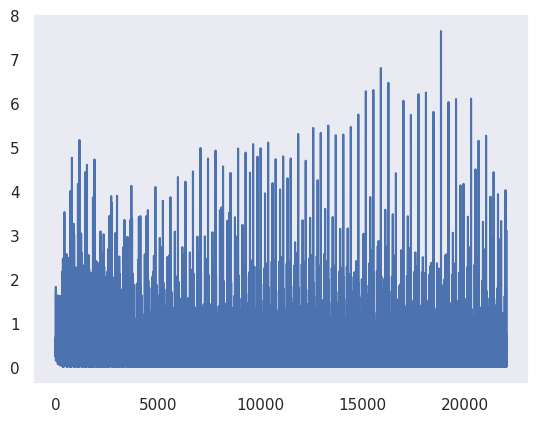

In [19]:
plt.plot(train_losses)

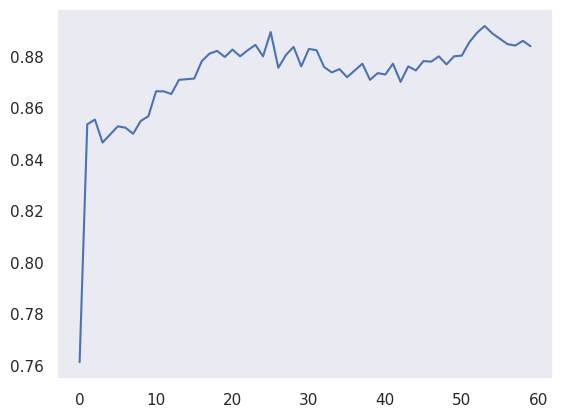

In [20]:
plt.plot(test_accuracy)

In [21]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3377/3808 (0.8868)
{'acc_detail': tensor([0.6327, 0.9634], device='cuda:0'),
 'acc_unweighted': tensor(0.7980, device='cuda:0'),
 'acc_weighted': tensor(0.8868, device='cuda:0'),
 'f1s_detail': tensor([0.7214, 0.9290], device='cuda:0'),
 'f1s_unweighted': tensor(0.8252, device='cuda:0'),
 'f1s_weighted': tensor(0.8809, device='cuda:0'),
 'precision_detail': tensor([0.8391, 0.8969], device='cuda:0'),
 'recall_detail': tensor([0.6327, 0.9634], device='cuda:0'),
 'rocauc': tensor(0.9276, device='cuda:0'),
 'rocauc_detail': tensor([0.9282, 0.9269], device='cuda:0'),
 'uar': tensor(0.7980, device='cuda:0'),
 'wap': tensor(0.8835, device='cuda:0')}


tensor([[ 558,  324],
        [ 107, 2819]], device='cuda:0')

In [22]:
model_path = f'{model_dir}physio16k_fold3_m13mfcc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
checkpoint_path = f'{model_dir}physio16k_fold3_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    # 'best_epoch': best_epoch,
    # 'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)